In [56]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [57]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [59]:

import torch

print(torch.__version__)

2.8.0+cu126


In [2]:
#드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#cd 연동
%cd /content/drive/MyDrive/ucube

/content/drive/MyDrive/ucube


In [ ]:
!pwd

/content/drive/MyDrive/ucube


In [ ]:
# 1단계: 나눔폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [4]:

# 2단계: matplotlib 재시작
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 캐시 새로고침
fm._load_fontmanager(try_read_cache=False)

# 3단계: 나눔폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("폰트 설정 완료! 런타임 재시작 이후 다시 시도해주세요")

폰트 설정 완료! 런타임 재시작 이후 다시 시도해주세요


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

# GPU 설정 or CPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

사용 디바이스: cuda


In [6]:
import pandas as pd

try:
    df = pd.read_csv('./improved_data/filled_data_improved.csv')
    print(" 데이터 로드 성공!")
except FileNotFoundError:
    print(" 파일을 찾을 수 없습니다: filled_data_improved.csv")
    raise

data = df.copy()
#data = data[data['channel_no']==1].sort_values('ts',ascending=True)
# 데이터 전처리가 되어있다고 가정. 실제py파일은 내용을 추가해야함
data['ts'] = pd.to_datetime(data['ts'])

 데이터 로드 성공!


In [6]:
data.head()

,ts,current_power_kw
0,2025-08-21 00:00:00,1.314
1,2025-08-21 00:15:00,1.668
2,2025-08-21 00:30:00,1.398
3,2025-08-21 00:45:00,1.788
4,2025-08-21 01:00:00,1.392


In [54]:
data.iloc[95,0]

Timestamp('2025-08-21 23:45:00')

In [7]:
# data의 ts컬럼은 datetime64로 이미 전처리가 되어있는 csv파일을 불러옴
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5437 entries, 0 to 5436
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ts                5437 non-null   datetime64[ns]
 1   current_power_kw  5437 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 85.1 KB


시간을 읽을 수 있는 특성을 추가해 보자
시간, 주말여부, (월. 이건 데이터가 더 많이 모였을 경우 사용하면 좋겠다 ), 휴일 여부

In [7]:
holidays_list = [
    # 데이터에는 없지만 형식적으로 2025년 중 쉬는 날을 전부 넣음
    '2025-01-01','2025-01-27','2025-01-28','2025-01-29','2025-01-30',

    '2025-03-03',

    '2025-05-05','2025-05-06',
    '2025-06-03','2025-06-06',

    '2025-08-15',

    '2025-10-03','2025-10-06','2025-10-07','2025-10-08','2025-10-09',

    '2025-12-25',
]

In [8]:
# 시계열 데이터는 시간의 흐름이 중요하기 때문에 불필요한 컬럼을 지우고 시간의 흐름을 보여줄 수 있는 데이터들로만 준비함.

data['hour']= data['ts'].dt.hour
data['day_of_week'] = data['ts'].dt.dayofweek
data['month'] = data['ts'].dt.month
# sin, cos를 적용해서 평일의 주말의 시간이 주기적인 특징을 보유함을 알려줌
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)


data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

data['date_str'] = data['ts'].dt.strftime('%Y-%m-%d')
data['is_holiday'] = data['date_str'].isin(holidays_list).astype(int)

data['power_lag_1'] = data['current_power_kw'].shift(1)      # 15분 전 값을 새로운 컬럼에 넣기
data['power_lag_4'] = data['current_power_kw'].shift(4)      # 1시간 전 값을 새로운 컬럼에 넣기
data['power_lag_12'] = data['current_power_kw'].shift(12)    # 3시간 전 값을 새로운 컬럼에 넣기
data['power_lag_96'] = data['current_power_kw'].shift(96)    # 24시간 전 값을 새로운 컬럼에 넣기

data['power_diff'] = data['current_power_kw'].diff()        # 15분전 값을 빼서 새로운 컬럼에 넣기
data['power_diff_2'] = data['current_power_kw'].diff(2)     # 30분전 값을 빼서 새로운 컬럼에 넣기
data['power_diff_4'] = data['current_power_kw'].diff(4)     # 1시간전 값을 빼서 새로운 컬럼에 넣기

#가속도 , 변동성을 추가햇는데 이 부분에 대해서는 급격하게 증가하는 peak를 예측하기 위해 넣었다고 할 수 있음
data['power_accel'] = data['power_diff'].diff()            # 가속도
# min_periods=1은 최소로 필요한 데이터의 개수
# .rolling(12)는 현재 행을 기준으로 이전 11개 + 현재 1개 = 총 12개 데이터를 하나의 그룹으로 봅니다.
# 12개의 지표(3시간)를 선택하여 전력의 표준편차를 구함. 즉, 표준편차가 크면 클수록 데이터의 변동성이 커짐을 의미.
data['power_std_12'] = data['current_power_kw'].rolling(12, min_periods=1).std()  # 변동성을 측정하는 지표

feature_columns = [
    # 시간/요일 특성 (4개)
    'hour_sin',
    'hour_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    # 이벤트 특성 (2개)
    'is_weekend',
    'is_holiday',

    'power_lag_1',      # 15분 전
    'power_lag_4',      # 1시간 전
    'power_lag_12',     # 3시간 전
    'power_lag_96',     # 24시간 전 ← 추가
    'power_diff',       # 15분 변화
    'power_diff_2',     # 30분 변화
    'power_diff_4',     # 1시간 변화
    'power_accel',      # 가속도 (diff의 diff즉 급격한 피크를 감지하기 위해서)
    'power_std_12',     # 변동성 (15*12 =180분. 3시간 동안 전력이 얼마나 들쭉날쭉한지를 보기위함)
]

In [9]:
data.iloc[4600:4605,:].head()

,ts,current_power_kw,hour,day_of_week,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,is_weekend,...,is_holiday,power_lag_1,power_lag_4,power_lag_12,power_lag_96,power_diff,power_diff_2,power_diff_4,power_accel,power_std_12
4600,2025-10-07 21:30:00,0.947,21,1,10,-0.707107,0.707107,0.781831,0.62349,0,...,1,1.044,1.044,1.032,0.984,-0.097,-0.554,-0.097,0.360,0.157362
4601,2025-10-07 21:45:00,1.020,21,1,10,-0.707107,0.707107,0.781831,0.62349,0,...,1,0.947,0.942,1.037,1.356,0.073,-0.024,0.078,0.170,0.157785
4602,2025-10-07 22:00:00,0.941,22,1,10,-0.500000,0.866025,0.781831,0.62349,0,...,1,1.020,1.501,0.972,0.977,-0.079,-0.006,-0.560,-0.152,0.159791
4603,2025-10-07 22:15:00,1.032,22,1,10,-0.500000,0.866025,0.781831,0.62349,0,...,1,0.941,1.044,1.049,0.990,0.091,0.012,-0.012,0.170,0.160052
4604,2025-10-07 22:30:00,1.091,22,1,10,-0.500000,0.866025,0.781831,0.62349,0,...,1,1.032,0.947,0.954,1.038,0.059,0.150,0.144,-0.032,0.156110


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5437 entries, 0 to 5436
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ts                5437 non-null   datetime64[ns]
 1   current_power_kw  5437 non-null   float64       
 2   hour              5437 non-null   int32         
 3   day_of_week       5437 non-null   int32         
 4   month             5437 non-null   int32         
 5   hour_sin          5437 non-null   float64       
 6   hour_cos          5437 non-null   float64       
 7   day_of_week_sin   5437 non-null   float64       
 8   day_of_week_cos   5437 non-null   float64       
 9   is_weekend        5437 non-null   int64         
 10  date_str          5437 non-null   object        
 11  is_holiday        5437 non-null   int64         
 12  power_lag_1       5436 non-null   float64       
 13  power_lag_4       5433 non-null   float64       
 14  power_lag_12      5425 n

In [11]:
data['power_lag_96'].head()
data.tail()

,ts,current_power_kw,hour,day_of_week,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,is_weekend,...,is_holiday,power_lag_1,power_lag_4,power_lag_12,power_lag_96,power_diff,power_diff_2,power_diff_4,power_accel,power_std_12
5432,2025-10-16 13:30:00,5.262,13,3,10,-0.258819,-0.965926,0.433884,-0.900969,0,...,0,5.144,3.332,4.830,5.144,0.118,-0.146,1.930,0.382,1.006300
5433,2025-10-16 13:45:00,5.164,13,3,10,-0.258819,-0.965926,0.433884,-0.900969,0,...,0,5.262,3.193,5.063,5.103,-0.098,0.020,1.971,-0.216,1.012975
5434,2025-10-16 14:00:00,5.253,14,3,10,-0.500000,-0.866025,0.433884,-0.900969,0,...,0,5.164,5.408,4.869,5.447,0.089,-0.009,-0.155,0.187,1.035515
5435,2025-10-16 14:15:00,5.171,14,3,10,-0.500000,-0.866025,0.433884,-0.900969,0,...,0,5.253,5.144,5.147,5.735,-0.082,0.007,0.027,-0.171,1.037078
5436,2025-10-16 14:30:00,5.091,14,3,10,-0.500000,-0.866025,0.433884,-0.900969,0,...,0,5.171,5.262,4.877,5.594,-0.080,-0.162,-0.171,0.002,1.047483


In [12]:
data.head(100)

,ts,current_power_kw,hour,day_of_week,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,is_weekend,...,is_holiday,power_lag_1,power_lag_4,power_lag_12,power_lag_96,power_diff,power_diff_2,power_diff_4,power_accel,power_std_12
0,2025-08-21 00:00:00,1.314,0,3,8,0.000000,1.000000,0.433884,-0.900969,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-21 00:15:00,1.668,0,3,8,0.000000,1.000000,0.433884,-0.900969,0,...,0,1.314,NaN,NaN,NaN,0.354,NaN,NaN,NaN,0.250316
2,2025-08-21 00:30:00,1.398,0,3,8,0.000000,1.000000,0.433884,-0.900969,0,...,0,1.668,NaN,NaN,NaN,-0.270,0.084,NaN,-0.624,0.184965
3,2025-08-21 00:45:00,1.788,0,3,8,0.000000,1.000000,0.433884,-0.900969,0,...,0,1.398,NaN,NaN,NaN,0.390,0.120,NaN,0.660,0.222944
4,2025-08-21 01:00:00,1.392,1,3,8,0.258819,0.965926,0.433884,-0.900969,0,...,0,1.788,1.314,NaN,NaN,-0.396,-0.006,0.078,-0.786,0.204397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2025-08-21 23:45:00,1.272,23,3,8,-0.258819,0.965926,0.433884,-0.900969,0,...,0,1.596,1.314,1.470,NaN,-0.324,-0.018,-0.042,-0.630,0.168907
96,2025-08-22 00:00:00,1.296,0,4,8,0.000000,1.000000,-0.433884,-0.900969,0,...,0,1.272,1.715,1.314,1.314,0.024,-0.300,-0.419,0.348,0.169692
97,2025-08-22 00:15:00,1.356,0,4,8,0.000000,1.000000,-0.433884,-0.900969,0,...,0,1.296,1.290,1.218,1.668,0.060,0.084,0.066,0.036,0.161808
98,2025-08-22 00:30:00,1.200,0,4,8,0.000000,1.000000,-0.433884,-0.900969,0,...,0,1.356,1.596,1.518,1.398,-0.156,-0.096,-0.396,-0.216,0.166156


In [ ]:
# 시간 ts를 인덱스로 변환?
# data = data.set_index('ts', inplace=True)

In [13]:
#NaN값 제거
# 모든 feature를 다 만든 후에, NaN이 하나라도 포함된 행을 삭제합니다.
data_cleaned = data.dropna()

# (선택) 얼마나 많은 데이터가 삭제되었는지 확인
print(f"원본 데이터 행 수: {len(data)}")
print(f"NaN 제거 후 행 수: {len(data_cleaned)}")
print(f"삭제된 행 수: {len(data) - len(data_cleaned)}")

data = data_cleaned

원본 데이터 행 수: 5437
NaN 제거 후 행 수: 5341
삭제된 행 수: 96


In [14]:
data['ts'].head()

,ts
96,2025-08-22 00:00:00
97,2025-08-22 00:15:00
98,2025-08-22 00:30:00
99,2025-08-22 00:45:00
100,2025-08-22 01:00:00


In [15]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5341 entries, 96 to 5436
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ts                5341 non-null   datetime64[ns]
 1   current_power_kw  5341 non-null   float64       
 2   hour              5341 non-null   int32         
 3   day_of_week       5341 non-null   int32         
 4   month             5341 non-null   int32         
 5   hour_sin          5341 non-null   float64       
 6   hour_cos          5341 non-null   float64       
 7   day_of_week_sin   5341 non-null   float64       
 8   day_of_week_cos   5341 non-null   float64       
 9   is_weekend        5341 non-null   int64         
 10  date_str          5341 non-null   object        
 11  is_holiday        5341 non-null   int64         
 12  power_lag_1       5341 non-null   float64       
 13  power_lag_4       5341 non-null   float64       
 14  power_lag_12      5341 non-n

In [16]:
len(data)

5341

In [17]:
data.iloc[1:3]

,ts,current_power_kw,hour,day_of_week,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,is_weekend,...,is_holiday,power_lag_1,power_lag_4,power_lag_12,power_lag_96,power_diff,power_diff_2,power_diff_4,power_accel,power_std_12
97,2025-08-22 00:15:00,1.356,0,4,8,0.0,1.0,-0.433884,-0.900969,0,...,0,1.296,1.290,1.218,1.668,0.060,0.084,0.066,0.036,0.161808
98,2025-08-22 00:30:00,1.200,0,4,8,0.0,1.0,-0.433884,-0.900969,0,...,0,1.356,1.596,1.518,1.398,-0.156,-0.096,-0.396,-0.216,0.166156


In [20]:
5341-96

5245

In [ ]:
len(feature_columns)

15

In [18]:
# 학습 시작 전에 model_config 딕셔너리 생성
# 이유는 미리 학습에 사용될 파라미터를 어떤것들을 사용할지에 대해서 미리 한눈에 파악하기 위해서임
model_config = {
    'n_features': len(feature_columns),
    'hidden_size': 128,
    'num_layers': 3,
    'dropout': 0.3,
    'batch_size': 64,
    'learning_rate': 0.001,
    'sequence_length': 96  # 기존 변수도 추가 가능
}
# sequence_length = 96
# 전력 데이터는 하루를 기준으로 비슷한 양상을 보이기 때문에 시퀀스는 96(24시간으로 선택)
# 데이터의 개수는 96개를 시퀀스로 하고 96개의 데이터는 하루의 데이터의 개수와 일치

In [19]:
model_config['sequence_length']

96

In [20]:
# X,y를 만드는 함수
def create_sequences(data, seq_length, feature_cols):
    X, y = [], []
    # 데이터가 범위를 벗어나지 않게 하기 위해( 슬라이딩 윈도우 방식 )
    for i in range(len(data) - seq_length): # 1 ~ 5245

        #총 5341개의 데이터의 개수에서 슬라이싱을 적용한다고 했는데, 반복 회수가 5245회라고 되어있다.
        # 0~95,1~96 ... 5245~5341 그래서 총 5245번의 회수만큼 반복
        X.append(data[feature_cols].iloc[i:i+seq_length].values) # 0~96, 1~ 97, 2~98, 3~99 ... ,5245~5341 행의 데이터 값만(values)를 x라는 리스트에 넣기
        y.append(data['current_power_kw'].iloc[i+seq_length]) # current_power_kw의 데이터를 y의 리스트에 넣기

    return np.array(X), np.array(y) # 그리고 np.array 형태로 변환해주기

# (5341-96 , 96 , 15)의 X shape
# (5341-96, )의 y shape
X, y = create_sequences(data, model_config['sequence_length'], feature_columns)
print(f" X shape: {X.shape}")
print(f" y shape: {y.shape}")

 X shape: (5245, 96, 15)
 y shape: (5245,)


In [21]:
len(feature_columns)

15

In [22]:
data.tail()

,ts,current_power_kw,hour,day_of_week,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,is_weekend,...,is_holiday,power_lag_1,power_lag_4,power_lag_12,power_lag_96,power_diff,power_diff_2,power_diff_4,power_accel,power_std_12
5432,2025-10-16 13:30:00,5.262,13,3,10,-0.258819,-0.965926,0.433884,-0.900969,0,...,0,5.144,3.332,4.830,5.144,0.118,-0.146,1.930,0.382,1.006300
5433,2025-10-16 13:45:00,5.164,13,3,10,-0.258819,-0.965926,0.433884,-0.900969,0,...,0,5.262,3.193,5.063,5.103,-0.098,0.020,1.971,-0.216,1.012975
5434,2025-10-16 14:00:00,5.253,14,3,10,-0.500000,-0.866025,0.433884,-0.900969,0,...,0,5.164,5.408,4.869,5.447,0.089,-0.009,-0.155,0.187,1.035515
5435,2025-10-16 14:15:00,5.171,14,3,10,-0.500000,-0.866025,0.433884,-0.900969,0,...,0,5.253,5.144,5.147,5.735,-0.082,0.007,0.027,-0.171,1.037078
5436,2025-10-16 14:30:00,5.091,14,3,10,-0.500000,-0.866025,0.433884,-0.900969,0,...,0,5.171,5.262,4.877,5.594,-0.080,-0.162,-0.171,0.002,1.047483


In [23]:
# train,val, test비율 분할
train_ratio = 0.7
val_ratio = 0.15

n_samples = X.shape[0] # 5245
n_features = X.shape[2] # 9

train_size = int(n_samples * train_ratio) # 5245*0.7 = 3671.5
val_size = int(n_samples * val_ratio) # 5245*0.15= 786.75

# 올바른 분할
X_train = X[:train_size] # 0~ 3671.5
X_val = X[train_size:train_size+val_size] # 3671.5 ~ 4458.25
X_test = X[train_size+val_size:] # 4458.25 ~ 5245

y_train = y[:train_size]# 0~ 3671.5
y_val = y[train_size:train_size+val_size]# 3671.5 ~ 4458.25
y_test = y[train_size+val_size:]# 4458.25 ~ 5245

print(f" Train: {len(X_train)}개")
print(f" Val:   {len(X_val)}개")
print(f" Test:  {len(X_test)}개")

 Train: 3671개
 Val:   786개
 Test:  788개


- reshape랑 flatten하는 이유는 뭘까?
  - X_train.shape = (3671, 96, 9)
  - MinMaxScaler는 2D만 받아요!
    입력: (샘플 수, feature 수)
    예: (100, 5) 2D라서 가능
    (100, 10, 5) 3D는 안 됨!

- 해결책
  - 3D -> 2D -> 스케일링 -> 3D
  0. 3D인 (3671, 96, 9)이고 값은 실제 데이터의 값들
  1. X_train.reshape(-1,9)로 (3671*96, 9) = (352416, 9)로 변환후
  2. 스케일링 -> minmaxscaling
  3. 다시 원래 형태인 3D로 변환 -> (3671, 96, 9)값은 0~1로 스케일됨


In [25]:
# 스케일링은 MinMaxSclaer 0~1사이의 값으로 변환하는 함수
# 데이터의 누수의 피드백을 수정해 train 부분에만 fit_transform을 적용 val, test에는 transform만 적용

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# X 스케일링
# fit_transform
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, n_features)).reshape(X_train.shape)

# transform
X_val_scaled = scaler_X.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape)

print(f"X 스케일링 완료")

# y 스케일링
# fit_transform
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# transform
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"y 스케일링 완료 완료")

# scaler 저장 코드
import pickle
from pathlib import Path
Path('./scalers').mkdir(parents=True, exist_ok=True)
# scaler_X 저장
with open('./scalers/scaler_X.pkl','wb') as f:
  pickle.dump(scaler_X, f)
# scaler_y저장
with open('./scalers/scaler_y.pkl','wb') as f:
  pickle.dump(scaler_y, f)


print(" Scaler 저장 완료!")
print(f"  - scaler_X: artifacts/scalers/scaler_X.pkl")
print(f"  - scaler_y: artifacts/scalers/scaler_y.pkl")


X 스케일링 완료
y 스케일링 완료 완료
 Scaler 저장 완료!
  - scaler_X: artifacts/scalers/scaler_X.pkl
  - scaler_y: artifacts/scalers/scaler_y.pkl

 Scaler 정보:
  X - Min: [-1.         -1.         -0.97492791 -0.90096887  0.        ]...
  X - Max: [1.         1.         0.97492791 1.         1.        ]...
  X - 피처 수: 15
  y - Min: 0.581
  y - Max: 8.032


In [ ]:
X_train_scaled.shape,X_val_scaled.shape,X_test_scaled.shape

((3671, 96, 15), (786, 96, 15), (788, 96, 15))

- flatten을 하는 이유는 뭘가?
  - minmaxscaler는 2D를 원합니다!
  - y_train.shape = (3671,)  # 1D 배열 -> 에러발생

- 해결책
  - 1D -> 2D -> 스케일링 -> 1D
  0. 1D인 (3671,)이고 값은 실제 데이터의 값들
  1. X_train.reshape(-1,1)로 2D (3671,) → (3671, 1)로 변환후
  2. 스케일링 -> minmaxscaling(0~1)
  3. 다시 원래 형태인 1D로 변환 (3671, 1) → (3671,)값은 0~1로 스케일됨

- reshape(-1,1)의 의미
  
  []를

  [[],

  [],

  [],

  []]으로


예시) y_train = [100, 105, 110, 98, 102]  # (5,)

    y_train.reshape(-1, 1)
    -1: "자동으로 계산해줘"
    1: 열은 1개

결과:

[[100],

 [105],

 [110],

 [98],

 [102]]

(5, 1)


- flatten은
  위의 reshape(-1,1)로 (5,1)이 되어버린 텐서를 다시 1차원으로 펴주는 역할을 한다
  - 결과: [100, 105, 110, 98, 102] 이렇게

In [ ]:
# y 스케일링
# fit_transform
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
# transform
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"y 스케일링 완료 완료")

y 스케일링 완료 완료


In [ ]:
y_train.shape,y_val.shape,y_test.shape
y_train_scaled.shape,y_val_scaled.shape,y_test_scaled.shape

((3671,), (786,), (788,))

In [ ]:
# FloatTensor
# pytorch는 tensor데이터 타입을 필요로 함 (numpy -> pytorch tensor로 변환) 딥러닝에서는 float32가 표
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)

X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val_scaled).to(device)

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

# TensorDataset
# 위의 float tensor를 tensor dataset으로 묶기 = (x,y)를 묶어줌
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


# batch_size =  한 번의 학습 단계(step)에서 처리하는 데이터 샘플의 개수
# 32, 64, 128 등
batch_size = 64


# Train에서 96(24시간)시퀀스로 한 하나의 층이 다르게 구현이 되더라도 학습땐 상관이 없도록 하기 위해서
# 순서 편향 방지 목적으로 shuffle=True를 하면 [효과: 다양한 시기의 데이터를 섞어서 학습, 계절 편향 감소, 일반화 능력 향상

# 즉, 모든패턴(평일, 주말, 연휴, 계절 등 )을 골고루 학습하기 위해서 shuffle을 사용한다.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# False
# 평가는 학습이 아니므로 false로 재현성을 높이기 위해서
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f" 배치 크기: {batch_size}")

 배치 크기: 64


In [ ]:
class SimpleGRU(nn.Module):
    """GRU모델로 다양한 drop out 과 num_layer를 적용 중 hidden_size도 128로 큰 편"""

    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(SimpleGRU, self).__init__()

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,# batch_first 가 False가 기본값인데, True로 해서 배치를 먼저 보게
            dropout=dropout if num_layers > 1 else 0
        )

        # fc1층과 fc2층 즉 2개의 층을 지정.
        # fc는 완전 연결층이라 부른다
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2) # 128, 64
        self.fc2 = nn.Linear(hidden_size // 2, 1)           # 64,   1

        # 활성화 함수로는 ReLU -> 기울기 소실 문제 완화
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.gru(x) # out(64,1)
        out = out[:, -1, :]  # 마지막 타임스텝  (64, 128) ← hidden_size=128

        out = self.fc1(out) # fc1층 (64, 128) → (64, 64)  128 → 64로 압축

        out = self.relu(out) # 음수를 제거 한다. 기울기 소실 문제 해결이 주 목적, 계산이 빠르
        out = self.dropout(out) # 일부를 0으로 dropout

        out = self.fc2(out)  # (64, 64) → (64, 1)로 최종 예측 + (5, 1, 1) → (5,) (마지막 1만 제거)
        return out.squeeze(-1)  #차원 제거 목적 ..마지막 차원이 1이면 제거..
                                # out(64,1)을 1D인 (64,)로 차원을 제거

#모델 설정
model = SimpleGRU(
    input_size=n_features,
    hidden_size=model_config['hidden_size'], # 128
    num_layers=model_config['num_layers'], # 3
    dropout=model_config['dropout'] # 0.3
).to(device)

#"학습 가능한 파라미터가 몇 개인가?"
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"모델 파라미터: {total_params:,}개")


모델 파라미터: 262,145개


In [ ]:
model_config['dropout']

0.3

MSEΣ (y-ŷ)²큰 오차에 민감일반적 회귀 (사용)

MAEΣ |y-ŷ|이상치에 강함 이상치 많을 때

Huber  MSE + MAE 혼합둘의 장점 이상치 있지만 민감도 필요

RMSE √(Σ(y-ŷ)²) MSE의 제곱근해석 쉬움 (단위 같음)


lr 값 선택:


0.1 이상매우 빠름발산 위험 ❌거의 안 씀

0.01 빠름불안정 가능간단한 모델

0.001 ✅안정적-일반적 선택

0.0001 매우 안정느림 🐌복잡한 모델

0.00001 극도로 안정매우 느림Fine-tuning

----
weight_decay = L2정규화

가중치가 너무 커지지 않게 제한

In [ ]:
# peak 가중치를 적용한 MSE Loss 클래스
class WeightedMSELoss(nn.Module):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def forward(self, pred, target):
        weight = torch.where(target > self.threshold, 2.0, 1.0)
        return torch.mean(weight * (pred - target)**2)

# train 데이터의 평균을 기준으로 threshold 계산
y_train_mean = y_train.mean()
peak_threshold = y_train_mean * 2.3  # 일단은 평균으로 쉽게 표현했는데 나중에 max로 해서 좀 더 peak에 적절하게 구현
# y를 scaled 버전으로 변환해야 함 (나중에 학습할 때 scaled 데이터 사용하므로)
peak_threshold_scaled = scaler_y.transform([[peak_threshold]])[0, 0]
criterion = WeightedMSELoss(threshold=peak_threshold_scaled)

In [ ]:
print(y_train.mean())
print(y_train.min())
print(y_train.max())
print(2.6*2.3)

2.610632476553683
0.581
8.032
5.9799999999999995


In [ ]:
# 손실함수로 MSELoss를 사용한 이유는? MSE=MeanSquaredError(평균 제곱 오차)
# 오차에 민감하게 반응하기 위해서. 즉 정전 위험, 설비 과부하에 대해 심각하게 받아들이기 위해
# 그래서 전력양이 강하게 올라가는 삐죽삐죽한 부분이 강조됨.
#criterion = nn.MSELoss()
#print("손실 함수: MSE")

손실 함수: MSE


In [ ]:
model_config['learning_rate']

0.001

In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = model_config['learning_rate'],          # learning rate 학습률 0.001
    weight_decay = 1e-4 )                         #1e-4
print("Optimizer: Adam (lr=0.001, weight_decay = 1e-4)")


# 아래의 ReduceLROnPlateau를 사용한 이유는? -> 학습률이 진전이 없으면 learning rate를 낮추는 스케쥴러라는데,



#데이터가 10000개 이하로 존재할 땐 사용하는 것을 추천
# 학습에 따른 최적화라고 하는데, 사실 이해가 와닿진 않네,..
# 학습률 스케줄
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min', # Val loss를 최소화
    factor = 0.5, # lr을 절반으로-> 0.7 -> 0.5
    patience = 20,# 10 epoch 동안 개선 없으면 -> 20 (best epoch가 늦어짐에 따라 patience자체는 효과 o)
    min_lr = 1e-5 # 최소 lr 1e-6 -> 1e-5
)
print("Scheduler: ReduceLROnPlateau")

Optimizer: Adam (lr=0.001, weight_decay = 1e-4)
Scheduler: ReduceLROnPlateau


In [ ]:
len(train_loader.dataset)

3671

In [ ]:
# epoch안에 들어가는 학습 함수

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train() # 학습 시작
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch) # forward 순전파 -> 예측값을 계산한다
        loss = criterion(outputs, y_batch) # 오차를 계산한다
        optimizer.zero_grad() # zero_grad -> 이전 gradient를 지워
        loss.backward()# 역전파로 gradient를 계산하라.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # RNN/LSTM/GRU에 표준적으로 1.0이 사용
        optimizer.step()#가중치 업데이트
        train_loss += loss.item() * X_batch.size(0) # train_loss를
    return train_loss / len(train_loader.dataset)# 3671

def validate_epoch(model, val_loader, criterion, device):
    model.eval() # 예측 시작
    val_loss = 0.0
    with torch.no_grad(): # no_grad 이 안에서는 gradient 추적을 하지 않는다.
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch) #순전파랑
            loss = criterion(outputs, y_batch)# loss만 계산
            val_loss += loss.item() * X_batch.size(0)
    return val_loss / len(val_loader.dataset)

#검증/학습 shape·dtype 검증
#outputs와 y_batch 모양/타입이 항상 (B,) 또는 (B,1)로 일치해야 함
#torch.cuda.amp 사용 고려

In [ ]:
model_config['hidden_size']

128

In [ ]:
model_config['sequence_length']

96

In [ ]:
num_epochs = 200 # 150 -> 200
best_val_loss = float('inf')
#patience = 40
#patience_counter = 0
train_losses = []
val_losses = []

print("학습 시작")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 체크포인트에 메타데이터 포함
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': best_val_loss,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'feature_columns': feature_columns,
            'sequence_length': model_config['sequence_length'],
            'model_config': model_config  # 모델 설정 정보 추가
        }, 'gru_model_2.pth')
        best_epoch = epoch + 1
    else:
        patience_counter += 1

    if (epoch + 1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train: {train_loss:.6f}, Val: {val_loss:.6f}")
        print(f"  Best: {best_val_loss:.6f} (Epoch {best_epoch})")
        #print(f"  Patience: {patience_counter}/{patience}, LR: {current_lr:.6f}")
        print("-" * 80)

    #if patience_counter >= patience:
    #    print(f" Early Stopping at epoch {epoch+1}")
    #    break


print(f" 학습 완료! Best: Epoch {best_epoch}, Val Loss: {best_val_loss:.6f}")




학습 시작
Epoch [5/200]
  Train: 0.014339, Val: 0.023968
  Best: 0.021792 (Epoch 3)
--------------------------------------------------------------------------------
Epoch [10/200]
  Train: 0.010785, Val: 0.018704
  Best: 0.018704 (Epoch 10)
--------------------------------------------------------------------------------
Epoch [15/200]
  Train: 0.009869, Val: 0.017753
  Best: 0.015989 (Epoch 13)
--------------------------------------------------------------------------------
Epoch [20/200]
  Train: 0.008863, Val: 0.014356
  Best: 0.013493 (Epoch 17)
--------------------------------------------------------------------------------
Epoch [25/200]
  Train: 0.009178, Val: 0.015264
  Best: 0.013493 (Epoch 17)
--------------------------------------------------------------------------------
Epoch [30/200]
  Train: 0.008002, Val: 0.014886
  Best: 0.013220 (Epoch 28)
--------------------------------------------------------------------------------
Epoch [35/200]
  Train: 0.007913, Val: 0.011639
  Best

In [ ]:
checkpoint = torch.load('gru_model_2.pth', weights_only=False)  # pytorch2.0+버젼 보안 강화 때문에 생긴것
model.load_state_dict(checkpoint['model_state_dict'])

print(f"베스트 모델 로드 (Epoch {checkpoint['epoch']})")

#베스트 모델을 저장만 하고, 최종적으로 테스트셋 성능을 확인하지 않음
#체크포인트에 epoch/best_val_loss를 함께 저장해서, 나중 셀 어디서든 torch.load로 안전하게 복구

베스트 모델 로드 (Epoch 168)


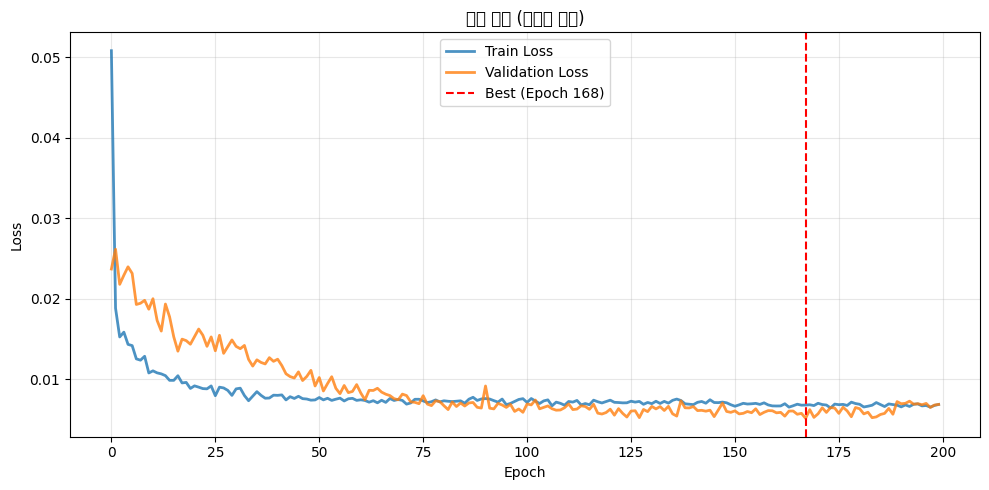

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.8, linewidth=2)
plt.plot(val_losses, label='Validation Loss', alpha=0.8, linewidth=2)
plt.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best (Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('학습 곡선 (최적화 버전)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### .extend
predictions와 actuals라는 []에 outputs의 결과를 넣는 과정이다.
이때, append와 비슷한 느낌이지만, append는 batch의 횟수만큼 반복이 지나면 리스트 안에 새로운 리스트를 만든다.

    결과 : predictions =

    [
    [예측1, 예측2, ..., 예측64],    # 1번 배치
    [예측65, 예측66, ..., 예측128],  # 2번 배치
    ...
    ]

    이렇게되어서 → shape: (12, 64) 또는 불규칙 한 상태가 된다.

하지만 extend는 하나의 리스트로 만들수 있는데

    결과 :  predictions = [예측1, 예측2, 예측3, ..., 예측787]

    이렇게 되면서 1차원 리스트인 → shape: (787,) 가 된다.


- numpy는 cpu환경에서만 작동하기때문에 cpu().numpy()를 해주는 것

In [ ]:
# 예측 수행

def predict(model, data_loader, device):
    model.eval() # 평가모드로 전환 (참고로 eval에서는 dropout을 사용하지 않는다. 예측할땐 모든 뉴런을 사용!)
    predictions = []
    actuals = []

    with torch.no_grad(): # 이 안에서는 gradient를 계산하지 않는다.
        for X_batch, y_batch in data_loader: # batch단위로 데이터 가져오기
            outputs = model(X_batch)
            #.extend는 append와 비슷한것 같지만, 1차원의 리스트를 만든나는 특징으로 tensor와 호환이 좋기 때문에 사용함.
            predictions.extend(outputs.cpu().numpy()) #numpy는 cpu환경에서만 작동하기때문에 cpu().numpy()를 해주는 것
            actuals.extend(y_batch.cpu().numpy())

    return np.array(predictions), np.array(actuals) # xxx_pred,  xxx_actual 모두 1차원 Numpy 형태로 반환(벡터 연선 목적)

print("예측 수행 중...\n")

# xxx_pred, actual 모두 1차원 리스트 형태
# model은 위의 모델, test_loader은  DataLoader이고
# DataLoader(test_dataset,batch_size=batch_size, shuffle=False)이고 device는 cuda or cpu중 하나
train_pred, train_actual = predict(model, train_loader, device)
val_pred, val_actual = predict(model, val_loader, device)
test_pred, test_actual = predict(model, test_loader, device)

print("예측 완료!")
print(f"Train: {len(train_pred)}개")
print(f"Val:   {len(val_pred)}개")
print(f"Test:  {len(test_pred)}개")

예측 수행 중...

예측 완료!
Train: 3671개
Val:   786개
Test:  788개


In [ ]:
# 1차원 리스트가 맞게 된 건지 한번 찍어보기
print(train_pred)
print(train_actual)


[0.09794413 0.08689271 0.08370371 ... 0.10986754 0.1116828  0.12208536]
[0.07743927 0.1595759  0.11367602 ... 0.06925245 0.14991276 0.08294189]


In [ ]:
# 역정규화

print("역정규화 수행 중...")
# 1차원을 2차원으로 해줘야함 그래야 .inverse_transform을 받을 수 있기 때문. 이렇게 reshape(-1,1)을 하고 나면 2D가 되고
# .inverse_transform이 완료가 되면 이후 1D로 바꾸어 주기 위해서 .flatten()을 해준다.
# 쉽게 말하면 1D -> (reshape) -> 2D (flatten) -> 1D
train_pred_original = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).flatten()
train_actual_original = scaler_y.inverse_transform(train_actual.reshape(-1, 1)).flatten()

val_pred_original = scaler_y.inverse_transform(val_pred.reshape(-1, 1)).flatten()
val_actual_original = scaler_y.inverse_transform(val_actual.reshape(-1, 1)).flatten()

test_pred_original = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).flatten()
test_actual_original = scaler_y.inverse_transform(test_actual.reshape(-1, 1)).flatten()

print("역정규화 완료")
print(f"Test 실제값: [{test_actual_original.min():.3f}, {test_actual_original.max():.3f}] kW")
print(f"Test 예측값: [{test_pred_original.min():.3f}, {test_pred_original.max():.3f}] kW")

역정규화 수행 중...
역정규화 완료
Test 실제값: [0.900, 7.806] kW
Test 예측값: [1.149, 6.191] kW


In [ ]:
print(train_actual_original.shape) # 처음 1차원 모습 but inverse_transform을 적용할 수 없음
print(train_actual.reshape(-1, 1).shape) # reshape를 통해 2차원으로 바꿔준 모습 이때 비로소 inverse_transform을 사용할 수 있음
print(train_actual.reshape(-1, 1).flatten().shape) # flatten으로 의해 펴져버린 모습 다시 원래 형태로 복원

(3671,)
(3671, 1)
(3671,)


성능평가

- MSE : (1/n) × Σ|실제 - 예측|

    예시:
    실제: [100, 105, 110]

    예측: [98, 107, 108]

    오차: [2, -2, 2]

    절댓값: [2, 2, 2]

    MAE: (2+2+2)/3 = 2.0 kW


의미:
평균적으로 2 kW 차이남
→ 이해하기 쉬움!
---
- RMSE : √((1/n) × Σ(실제 - 예측)²)
    예시:

    실제: [100, 105, 110]

    예측: [98, 107, 108]

    오차: [2, -2, 2]

    제곱: [4, 4, 4]

    평균: 4

    RMSE: √4 = 2.0 kW
특징:
큰 오차에 더 민감!
오차 10 → 100 (제곱)
오차 1 → 1 (제곱)
---
- R2 : R² = 1 - (Σ(실제 - 예측)²) / (Σ(실제 - 평균)²)
    범위: -∞ ~ 1
    1.0: 완벽한 예측
    0.9: 매우 좋음
    0.7: 괜찮음
    0.5: 그저 그럼
    0.0: 평균 예측과 같음
    음수: 평균보다 나쁨

예시:
R² = 0.89
→ "모델이 분산의 89%를 설명함"
→ 꽤 좋은 성능!
---


In [ ]:
# 성능 평가

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, dataset_name="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100


    print(f"{dataset_name} Set 성능 평가")
    print(f"{'='*80}")
    print(f"MAE (평균 절대 오차):        {mae:.4f} kW")
    print(f"RMSE (평균 제곱근 오차):     {rmse:.4f} kW")
    print(f"R² Score (결정 계수):        {r2:.4f}")
    print(f"MAPE (평균 절대 백분율 오차): {mape:.2f}%")
    print(f"{'='*80}")

    return mae, rmse, r2, mape

print("성능 평가 시작")
train_metrics = evaluate_model(train_actual_original, train_pred_original, "Train")
val_metrics = evaluate_model(val_actual_original, val_pred_original, "Validation")
test_metrics = evaluate_model(test_actual_original, test_pred_original, "Test")

성능 평가 시작
Train Set 성능 평가
MAE (평균 절대 오차):        0.3318 kW
RMSE (평균 제곱근 오차):     0.5162 kW
R² Score (결정 계수):        0.9173
MAPE (평균 절대 백분율 오차): 15.16%
Validation Set 성능 평가
MAE (평균 절대 오차):        0.3814 kW
RMSE (평균 제곱근 오차):     0.5220 kW
R² Score (결정 계수):        0.8617
MAPE (평균 절대 백분율 오차): 30.24%
Test Set 성능 평가
MAE (평균 절대 오차):        0.3988 kW
RMSE (평균 제곱근 오차):     0.5886 kW
R² Score (결정 계수):        0.8810
MAPE (평균 절대 백분율 오차): 23.75%


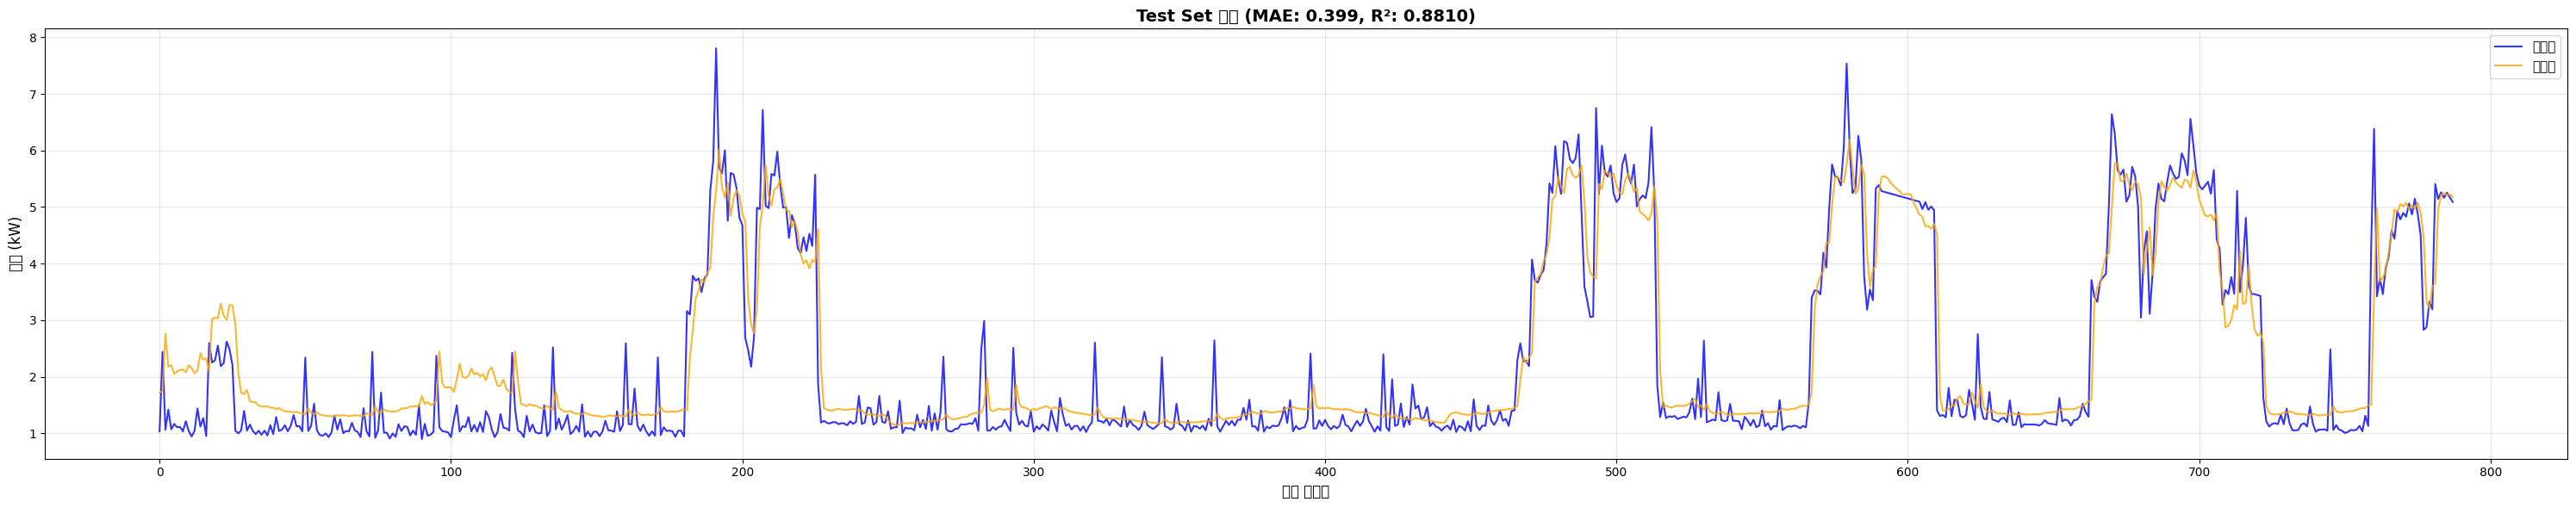

In [ ]:
# 시각화

# 1. Test Set 전체
plt.figure(figsize=(30, 6))
plt.plot(test_actual_original, label='실제값', alpha=0.8, linewidth=1.5, color='blue')
plt.plot(test_pred_original, label='예측값', alpha=0.8, linewidth=1.5, color='orange')
plt.xlabel('샘플 인덱스', fontsize=12)
plt.ylabel('전력 (kW)', fontsize=12)
plt.title(f'Test Set 예측 (MAE: {test_metrics[0]:.3f}, R²: {test_metrics[2]:.4f})',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

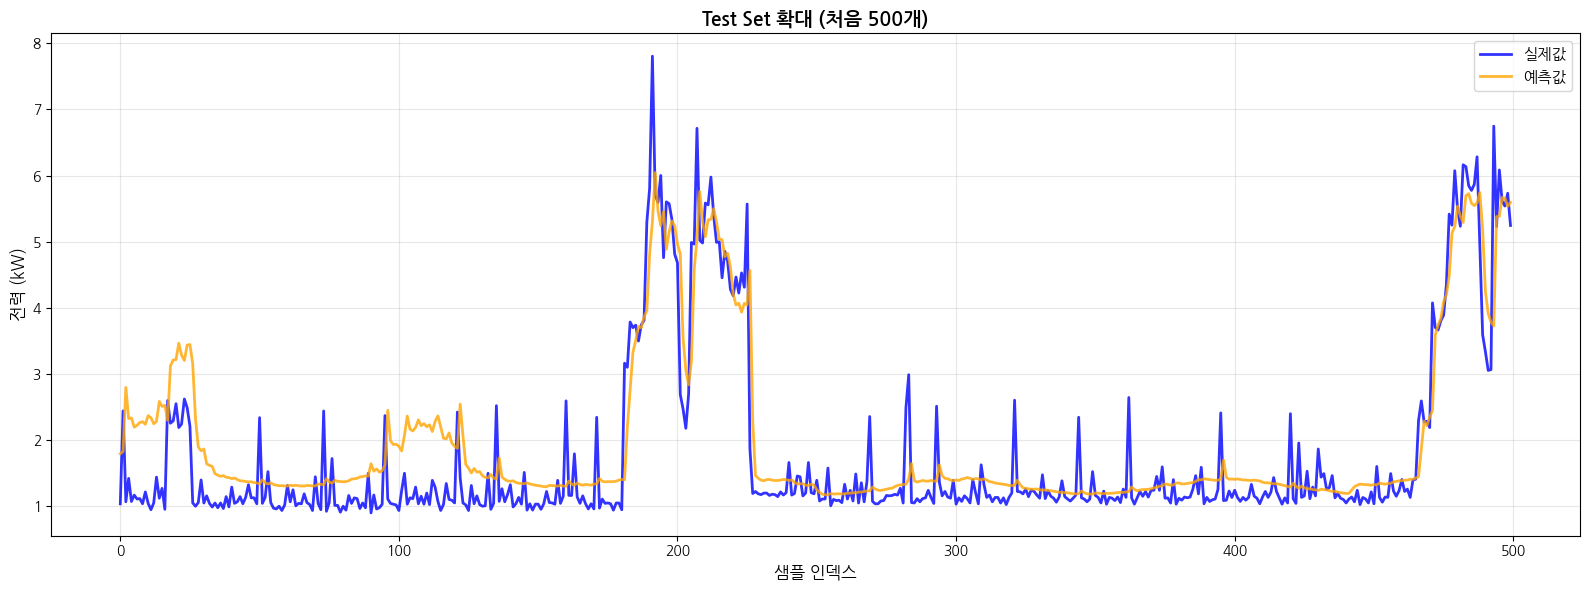

In [ ]:
# 2. 일부 확대
zoom = 500
plt.figure(figsize=(16, 6))
plt.plot(test_actual_original[:zoom], label='실제값', alpha=0.8, linewidth=2, color='blue')
plt.plot(test_pred_original[:zoom], label='예측값', alpha=0.8, linewidth=2, color='orange')
plt.xlabel('샘플 인덱스', fontsize=12)
plt.ylabel('전력 (kW)', fontsize=12)
plt.title(f'Test Set 확대 (처음 {zoom}개)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

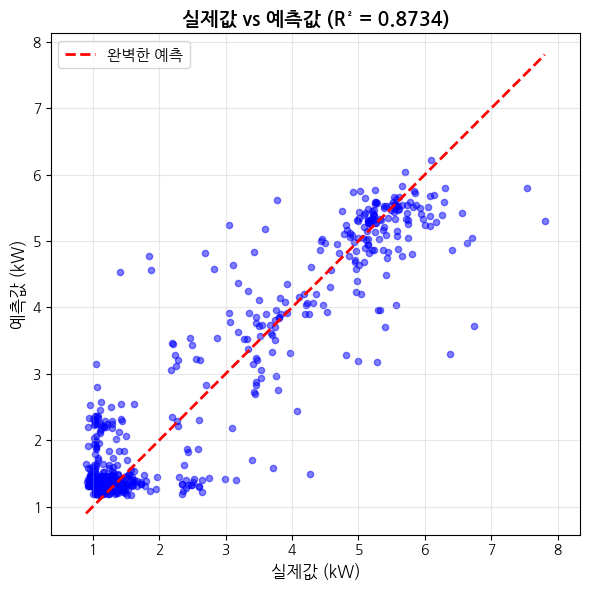

In [ ]:
# 3. 산점도
plt.figure(figsize=(6, 6))
plt.scatter(test_actual_original, test_pred_original, alpha=0.5, s=20, color='blue')
plt.plot([test_actual_original.min(), test_actual_original.max()],
         [test_actual_original.min(), test_actual_original.max()],
         'r--', lw=2, label='완벽한 예측')
plt.xlabel('실제값 (kW)', fontsize=12)
plt.ylabel('예측값 (kW)', fontsize=12)
plt.title(f'실제값 vs 예측값 (R² = {test_metrics[2]:.4f})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Best 모델 정보를 텍스트 파일로 저장
with open('gru_model.txt', 'w', encoding='utf-8') as f:
    f.write("="*100 + "\n")
    f.write("BEST 모델 상세 정보\n")
    f.write("="*100 + "\n\n")

    f.write(f"파일명: new_2.3_peak.pth\n\n")

    f.write(f"🏆 학습 결과:\n")
    f.write(f"   - Best Epoch: {checkpoint['epoch']}/{num_epochs}\n")
    f.write(f"   - Best Train Loss: {checkpoint['train_loss']:.6f}\n")
    f.write(f"   - Best Val Loss: {checkpoint['val_loss']:.6f}\n\n")

    f.write(f"🔧 모델 구조:\n")
    f.write(f"   - Model Type: SimpleGRU\n")
    f.write(f"   - Hidden Size: {model_config['hidden_size']}\n")
    f.write(f"   - Num Layers: {model_config['num_layers']}\n")
    f.write(f"   - Dropout: {model_config['dropout']}\n")
    f.write(f"   - Input Features: {model_config['n_features']}\n")
    f.write(f"   - Sequence Length: {model_config['sequence_length']}\n\n")

    f.write(f"⚙️ 학습 설정:\n")
    f.write(f"   - Batch Size: {model_config['batch_size']}\n")
    f.write(f"   - Learning Rate: {model_config['learning_rate']}\n")
    f.write(f"   - Total Epochs: {num_epochs}\n")
    f.write(f"   - Optimizer: Adam\n")
    f.write(f"   - Loss Function: MSE\n")
    f.write(f"   - Scheduler: ReduceLROnPlateau\n\n")

    f.write(f"📊 데이터 정보:\n")
    f.write(f"   - Train Size: {len(X_train):,}개\n")
    f.write(f"   - Val Size: {len(X_val):,}개\n")
    f.write(f"   - Test Size: {len(X_test):,}개\n\n")

    f.write(f"🎯 테스트 성능:\n")
    f.write(f"   - Test MAE: {test_metrics[0]:.4f} kW\n")
    f.write(f"   - Test RMSE: {test_metrics[1]:.4f} kW\n")
    f.write(f"   - Test R²: {test_metrics[2]:.4f}\n")
    f.write(f"   - Test MAPE: {test_metrics[3]:.2f}%\n\n")

    f.write("="*100 + "\n")

print("모델 정보가 'gru_model.txt' 파일로 저장되었습니다!")

모델 정보가 'gru_model.txt' 파일로 저장되었습니다!


# 모델 로드 및 사용

In [ ]:
import pandas as pd

# data = data[data['channel_no']==1].sort_values('ts',ascending=True)
# 데이터 전처리가 되어있다고 가정. 실제py파일은 내용을 추가해야함
try:
    df = pd.read_csv('./improved_data/filled_data_improved.csv')
    data = df.copy()

    data['ts'] = pd.to_datetime(data['ts'])

    holidays_list = [

    '2025-01-01','2025-01-27','2025-01-28','2025-01-29','2025-01-30',

    '2025-03-03',

    '2025-05-05','2025-05-06',
    '2025-06-03','2025-06-06',

    '2025-08-15',

    '2025-10-03','2025-10-06','2025-10-07','2025-10-08','2025-10-09',

    '2025-12-25',
    ]

    data['hour']= data['ts'].dt.hour
    data['day_of_week'] = data['ts'].dt.dayofweek
    data['month'] = data['ts'].dt.month

    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)


    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

    data['date_str'] = data['ts'].dt.strftime('%Y-%m-%d')
    data['is_holiday'] = data['date_str'].isin(holidays_list).astype(int)

    data['power_lag_1'] = data['current_power_kw'].shift(1)      # 15분 전
    data['power_lag_4'] = data['current_power_kw'].shift(4)      # 1시간 전
    data['power_lag_12'] = data['current_power_kw'].shift(12)    # 3시간 전
    data['power_lag_96'] = data['current_power_kw'].shift(96)    # 24시간 전

    data['power_diff'] = data['current_power_kw'].diff()        # 15분 변화
    data['power_diff_2'] = data['current_power_kw'].diff(2)     # 30분 변화
    data['power_diff_4'] = data['current_power_kw'].diff(4)     # 1시간 변화

    data['power_accel'] = data['power_diff'].diff()            # 가속도
    data['power_std_12'] = data['current_power_kw'].rolling(12, min_periods=1).std()  # 변동성

    feature_columns = [

    'hour_sin',
    'hour_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'is_weekend',
    'is_holiday',
    'power_lag_1',      # 15분 전
    'power_lag_4',      # 1시간 전
    'power_lag_12',     # 3시간 전
    'power_lag_96',     # 24시간 전 ← 추가
    'power_diff',       # 15분 변화
    'power_diff_2',     # 30분 변화
    'power_diff_4',     # 1시간 변화
    'power_accel',      # 가속도 (diff의 diff즉 급격한 피크를 감지하기 위해서)
    'power_std_12',     # 변동성 (15*12 =180분. 3시간 동안 전력이 얼마나 들쭉날쭉한지를 보기위함)
    ]

    print(" 데이터 로드 성공!")

except FileNotFoundError:
    print(" 파일을 찾을 수 없습니다: filled_data_improved.csv")
    raise


 데이터 로드 성공!


# 모델 로드


In [ ]:
# 예측 사용자에게 입력을 받는 것을 예시로
#1. 모델 로드
checkpoint = torch.load('gru_model.pth', weights_only = False, map_location=device)

config = checkpoint['model_config']
# checkpoint
print(f"  - epoch:  {checkpoint['epoch']}")
#print(f"  - model_state_dict:  {checkpoint['model_state_dict']}")
#print(f"  - optimizer_state_dict:  {checkpoint['optimizer_state_dict']}")
print(f"  - train_loss:  {checkpoint['train_loss']}")
print(f"  - val_loss:  {checkpoint['val_loss']}")
print(f"  - scaler_X:  {checkpoint['scaler_X']}")
print(f"  - feature_columns:  {checkpoint['feature_columns']}")
print(f"  - sequence_length:  {checkpoint['sequence_length']}")
#config 정보
print(f"  - N Features Size:  {config['n_features']}")
print(f"  - Hidden Size:  {config['hidden_size']}")
print(f"  - Num Layers:   {config['num_layers']}")
print(f"  - Dropout:      {config['dropout']}")
print(f"  - Batch Size:  {config['batch_size']}")
print(f"  - Learning rate:  {config['learning_rate']}")
print(f"  - Sequence Length:  {config['sequence_length']}")

  - epoch:  97
  - train_loss:  0.006887429200954587
  - val_loss:  0.005772603852271503
  - scaler_X:  MinMaxScaler()
  - feature_columns:  ['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'is_weekend', 'is_holiday', 'power_lag_1', 'power_lag_4', 'power_lag_12', 'power_lag_96', 'power_diff', 'power_diff_2', 'power_diff_4', 'power_accel', 'power_std_12']
  - sequence_length:  96
  - N Features Size:  15
  - Hidden Size:  128
  - Num Layers:   3
  - Dropout:      0.3
  - Batch Size:  64
  - Learning rate:  0.001
  - Sequence Length:  96


In [ ]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_loss', 'val_loss', 'scaler_X', 'scaler_y', 'feature_columns', 'sequence_length', 'model_config'])

In [ ]:
config.keys()

dict_keys(['n_features', 'hidden_size', 'num_layers', 'dropout', 'batch_size', 'learning_rate', 'sequence_length'])

# 모델 설정 (예측할때에도 모델을 생성해주어야합니다.)

In [ ]:
class SimpleGRU(nn.Module):
    """GRU모델로 다양한 drop out 과 num_layer를 적용 중 hidden_size도 128로 큰 편"""

    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(SimpleGRU, self).__init__()

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,# batch_first 가 False가 기본값인데, True로 해서 배치를 먼저 보게
            dropout=dropout if num_layers > 1 else 0
        )

        # fc1층과 fc2층 즉 2개의 층을 지정.
        # fc는 완전 연결층이라 부른다
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2) # 128, 64
        self.fc2 = nn.Linear(hidden_size // 2, 1)           # 64,   1

        # 활성화 함수로는 ReLU -> 기울기 소실 문제 완화
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.gru(x) # out(64,1)
        out = out[:, -1, :]  # 마지막 타임스텝  (64, 128) ← hidden_size=128

        out = self.fc1(out) # fc1층 (64, 128) → (64, 64)  128 → 64로 압축

        out = self.relu(out) # 음수를 제거 한다. 기울기 소실 문제 해결이 주 목적, 계산이 빠르
        out = self.dropout(out) # 일부를 0으로 dropout

        out = self.fc2(out)  # (64, 64) → (64, 1)로 최종 예측 + (5, 1, 1) → (5,) (마지막 1만 제거)
        return out.squeeze(-1)  #차원 제거 목적 ..마지막 차원이 1이면 제거..
                                # out(64,1)을 1D인 (64,)로 차원을 제거


In [ ]:
# 새로운 모델 객체 생성 후 가중치 로

model_loaded = SimpleGRU(
    input_size=config['n_features'],      # 저장된 값 사용
    hidden_size=config['hidden_size'],    # 저장된 값 사용
    num_layers=config['num_layers'],      # 저장된 값 사용
    dropout=config['dropout']             # 저장된 값 사용
).to(device)

model_loaded.load_state_dict(checkpoint['model_state_dict'])
model_loaded.eval() # 평가모드

SimpleGRU(
  (gru): GRU(15, 128, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

# 스케일러 불러오기

In [ ]:
# 사용할 스케일러도 불러오기
scaler_X_loaded = checkpoint['scaler_X']
scaler_y_loaded = checkpoint['scaler_y']
feature_columns_loaded = checkpoint['feature_columns']
sequence_length_loaded = checkpoint['sequence_length'] # 96 개의 시퀀스 길이 불러온거

In [ ]:
print(checkpoint['feature_columns'])
print("\n")
print(checkpoint['sequence_length'])

['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'is_weekend', 'is_holiday', 'power_lag_1', 'power_lag_4', 'power_lag_12', 'power_lag_96', 'power_diff', 'power_diff_2', 'power_diff_4', 'power_accel', 'power_std_12']


96


# 사용해야 하는 함수
- create_features
- predict_future_recursive

In [ ]:
import numpy as np
import pandas as pd

# (holidays_list는 이전에 정의되어 있어야 함)

def create_features(power_series):
    """
    전력 시계열 *DataFrame*으로부터 특성을 생성하는 함수
    (Lag 인덱스 버그 수정 버전)

    Parameters:
    power_series : pandas.DataFrame
        'ts'와 'current_power_kw' 컬럼 포함.
        Lag 96을 계산하기 위해 최소 97개 이상의 행이 필요합니다.
        (T, T-1, ..., T-96)
        predict_future_recursive에서 192개를 전달하므로 안전합니다.

    Returns:
    features : numpy array (15,)
    """

    # 1. 시간 특성 계산 (기존과 동일, 올바름)
    last_ts = power_series['ts'].iloc[-1]
    hour = last_ts.hour
    day_of_week = last_ts.dayofweek

    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    day_of_week_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_of_week_cos = np.cos(2 * np.pi * day_of_week / 7)

    is_weekend = int(day_of_week in [5, 6])
    date_str = last_ts.strftime('%Y-%m-%d')
    is_holiday = int(date_str in holidays_list)

    # 2. Lag / Diff / Accel / Std 계산 (버그 수정!)
    power_values = power_series['current_power_kw'].values
    n = len(power_values) # 현재 192개

    # T 시점은 power_values[-1] 입니다.
    # T-1 시점은 power_values[-2] 입니다.
    # T-N 시점은 power_values[-(N+1)] 입니다.

    #  Lag (지연) 특성 수정
    power_lag_1 = power_values[-2] if n >= 2 else 0    # T-1
    power_lag_4 = power_values[-5] if n >= 5 else 0    # T-4
    power_lag_12 = power_values[-13] if n >= 13 else 0   # T-12
    power_lag_96 = power_values[-97] if n >= 97 else 0   # T-96

    #  Diff (차분) 특성 수정 (T 시점 기준)
    power_diff = power_values[-1] - power_values[-2] if n >= 2 else 0   # T - (T-1)
    power_diff_2 = power_values[-1] - power_values[-3] if n >= 3 else 0   # T - (T-2)
    power_diff_4 = power_values[-1] - power_values[-5] if n >= 5 else 0   # T - (T-4)

    #  Accel (가속도) 특성 수정
    if n >= 3:
        diff_now = power_values[-1] - power_values[-2]
        diff_prev = power_values[-2] - power_values[-3]
        power_accel = diff_now - diff_prev
    else:
        power_accel = 0

    #  Std (변동성) 특성 (이건 기존 로직도 괜찮았습니다)
    # T 시점을 포함한 최근 12개(3시간)의 변동성
    power_std_12 = np.std(power_values[-12:]) if n >= 12 else 0

    # 3. 반환 (순서 중요!)
    # feature_columns 순서와 정확히 일치해야 함
    return np.array([
        hour_sin,
        hour_cos,
        day_of_week_sin,
        day_of_week_cos,
        is_weekend,
        is_holiday,
        power_lag_1,    # 수정됨
        power_lag_4,    # 수정됨
        power_lag_12,   # 수정됨
        power_lag_96,   # 수정됨
        power_diff,     # 수정됨
        power_diff_2,   # 수정됨
        power_diff_4,   # 수정됨
        power_accel,    # 수정됨
        power_std_12    # (기존과 동일)
    ])

print(" 'create_features' 함수가 버그 수정 버전으로 정의되었습니다.")

 'create_features' 함수가 버그 수정 버전으로 정의되었습니다.


In [ ]:
def predict_future_recursive(model, initial_sequence, scaler_X, scaler_y,
                             n_steps, feature_cols, seq_len, n_feat, device):
    """
    재귀적 방식으로 미래 예측 (DataFrame 윈도우 추적 방식)
    예측을 다음 예측의 입력으로 사용하는 Recursive형태
    'create_features'에 DataFrame을 전달하도록 수정됨
    model = 학습된 gru모델
    initial_sequence = 초기 96개 데이터
    scaler_X = X스케일러 (minmaxscaler)
    scaler_y = y스케일러
    n_steps =몇 스텝을 예측할 건지
    feature_cols = 특성 컬럼명 리스트
    seq_len =시퀀스 길이(96)
    n_feat = 특성 개수(ex 15)
    device = (cuda or cpu)
    """
    model.eval()
    predictions = []

    #  수정: 192개 윈도우 유지 (96 현재 + 96 과거)
    # 'create_features' 함수에 전달할 DataFrame 윈도우
    current_raw_df = initial_sequence[['ts', 'current_power_kw']].copy()

    # 만약 initial_sequence가 96개면, 앞에 96개 더 추가
    if len(current_raw_df) < 192:
        # data의 마지막 192개 사용
        current_raw_df = data.iloc[-192:][['ts', 'current_power_kw']].copy()

     # 2. 모델 입력은 마지막 96개만 사용  모델 입력을 위한 '특성' NumPy 배열 값들
    current_sequence = initial_sequence[feature_cols].values

    with torch.no_grad():
        for step in range(n_steps):
            # 3. 스케일링 예시 => (96, 15) → (96*15) → 스케일링 → 다시 (96, 15) → (1, 96, 15)
            seq_scaled = scaler_X.transform(current_sequence.reshape(-1, n_feat))
            seq_scaled = seq_scaled.reshape(1, seq_len, n_feat)
            # 4. 모델 예측
            seq_tensor = torch.FloatTensor(seq_scaled).to(device)
            pred_scaled = model(seq_tensor).cpu().numpy()
            # 5. 역스케일링
            pred_original = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0]
            predictions.append(pred_original)

            # 6. 'DataFrame 윈도우' 업데이트 (핵심!) 15분 추가
            last_ts = current_raw_df['ts'].iloc[-1]
            next_ts = last_ts + pd.Timedelta(minutes=15)
            new_raw_row = pd.DataFrame({
                'ts': [next_ts],
                'current_power_kw': [pred_original]
            })
            # 윈도우 슬라이딩: 맨 앞 1개 제거 + 맨 뒤에 새 행 추가
            # 192개 유지: 맨 앞 1개 제거 + 맨 뒤 1개 추가
            current_raw_df = pd.concat(
                [current_raw_df.iloc[1:], new_raw_row],
                ignore_index=True
            )


            # 7. 'create_features'에 DataFrame 전달 (핵심!)
            # current_raw_df (192행)를 받아서
            # → lag, diff, sin/cos 등 모든 특성 재계산
            # → 마지막 행의 특성값 (1행 × 15개) 반환
            new_features = create_features(current_raw_df)

            # 모델 입력 시퀀스는 마지막 96개만
            current_sequence = np.vstack([current_sequence[1:], new_features])

    return predictions

# 예측 수행

In [ ]:
# 예측 수행
# 초기 시퀀스: 마지막 96개 데이터 사용
initial_sequence = data.iloc[-sequence_length_loaded:].copy()

# 예측 시작 시각 (마지막 데이터 + 15분)
prediction_start_time = initial_sequence['ts'].iloc[-1] + pd.Timedelta(minutes=15)

print(f"\n현재 시각(마지막 데이터가 측정된 시간): {initial_sequence['ts'].iloc[-1]}")
print(f"예측 시작 시각: {prediction_start_time}")
print(f"초기 시퀀스 기간: {initial_sequence['ts'].iloc[0]} ~ {initial_sequence['ts'].iloc[-1]}")
print(f"초기 시퀀스 데이터 개수: {len(initial_sequence)}개")
print(f"현재 전력: {initial_sequence['current_power_kw'].iloc[-1]:.2f} kW")


현재 시각(마지막 데이터가 측정된 시간): 2025-10-16 14:30:00
예측 시작 시각: 2025-10-16 14:45:00
초기 시퀀스 기간: 2025-10-15 14:45:00 ~ 2025-10-16 14:30:00
초기 시퀀스 데이터 개수: 96개
현재 전력: 5.09 kW


In [ ]:
predict_config = {
    '15min': 1,      # 1시간 = 4 스텝
    '30min': 2,     # 3시간 = 12 스텝
    '1h': 4,     # 6시간 = 24 스텝
    '3h': 12,     # 24시간 = 96 스텝
    '6h': 24
}

# 예측 결과를 저장할 딕셔너리
predictions_dict = {}
pred_times_dict = {}

# 반복문으로 예측 + 타임스탬프 생성
for horizon, n_steps in predict_config.items():
    print(f"\n[{horizon} 예측 시작]")

    # 예측 수행
    # 위에서 정의했던 predict_future_recursive를 통해 예측의 prediction 리스트 [] 를 생성하고 그걸 predictions_dict[horizon]에 넣는다.

    predictions_dict[horizon] = predict_future_recursive(
        model=model_loaded,
        initial_sequence=initial_sequence,
        scaler_X=scaler_X_loaded,
        scaler_y=scaler_y_loaded,
        n_steps=n_steps,
        feature_cols=feature_columns_loaded,
        seq_len=sequence_length_loaded,
        n_feat=config['n_features'],
        device=device
    )

    # 타임스탬프 생성
    pred_times_dict[horizon] = [
        prediction_start_time + pd.Timedelta(minutes=15*i)
        for i in range(n_steps)
    ]

    print(f" {horizon} 예측 완료: {len(predictions_dict[horizon])}개 시점")



in 예측 시작]
 15min 예측 완료: 1개 시점

in 예측 시작]
 30min 예측 완료: 2개 시점

[1h 예측 시작]
 1h 예측 완료: 4개 시점

[3h 예측 시작]
 3h 예측 완료: 12개 시점

[6h 예측 시작]
 6h 예측 완료: 24개 시점


In [ ]:
predictions_dict.keys()

dict_keys(['15min', '30min', '1h', '3h', '6h'])

In [ ]:
print("예측 결과 요약")


current_power = initial_sequence['current_power_kw'].iloc[-1]
print(f"\n현재 전력: {current_power:.2f} kW")
print(f"예측 시작: {prediction_start_time}\n")

print(f"{'구간':^10} {'스텝수':^8} {'평균 (kW)':^12}")

for horizon, predictions in predictions_dict.items():
    print(f"{horizon:^10} {len(predictions):^8} "
          f"{np.mean(predictions):^12.2f}")


예측 결과 요약

현재 전력: 5.09 kW
예측 시작: 2025-10-16 14:45:00

    구간       스텝수      평균 (kW)   
  15min       1         5.14    
  30min       2         5.14    
    1h        4         5.13    
    3h        12        4.75    
    6h        24        3.50    


In [ ]:
# 과거 데이터 (최근 3일)
lookback_days = 3
lookback_samples = 96 * lookback_days  # 96 = 하루 15분 간격
historical_data = data.iloc[-lookback_samples:].copy()

print(f"과거 데이터 준비 완료 (최근 {lookback_days}일)")

과거 데이터 준비 완료 (최근 3일)


# 시각화


[시각화 1] 72시간 예측 그래프


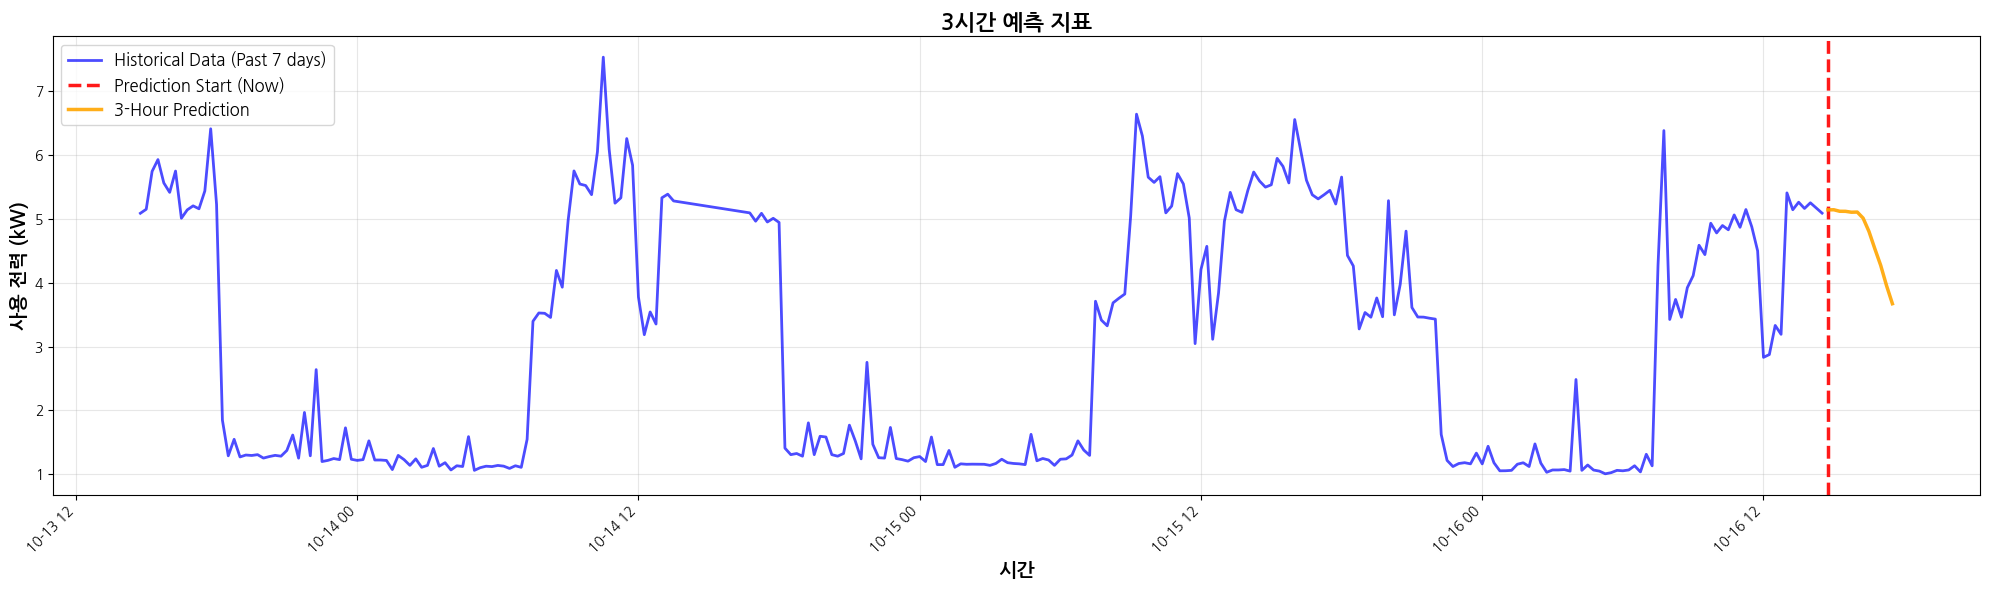

In [ ]:
print("\n[시각화 1] 72시간 예측 그래프")

plt.figure(figsize=(20, 6))

# 과거 데이터 (파란선)
plt.plot(historical_data['ts'], historical_data['current_power_kw'],
         label='Historical Data (Past 7 days)',
         color='blue', linewidth=2, alpha=0.7)

# 예측 시작점 (빨간 점선)
plt.axvline(x=prediction_start_time, color='red', linestyle='--',
            linewidth=2.5, label='Prediction Start (Now)', alpha=0.9)

# 72시간 예측 (주황선)
plt.plot(pred_times_dict['3h'], predictions_dict['3h'],
         label='3-Hour Prediction',
         color='orange', linewidth=2.5, alpha=0.9)

# 그래프 꾸미기
plt.xlabel('시간', fontsize=14, fontweight='bold')
plt.ylabel('사용 전력 (kW)', fontsize=14, fontweight='bold')
plt.title('3시간 예측 지표', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


[시각화 2] 다중 구간 비교 그래프 (2×2)


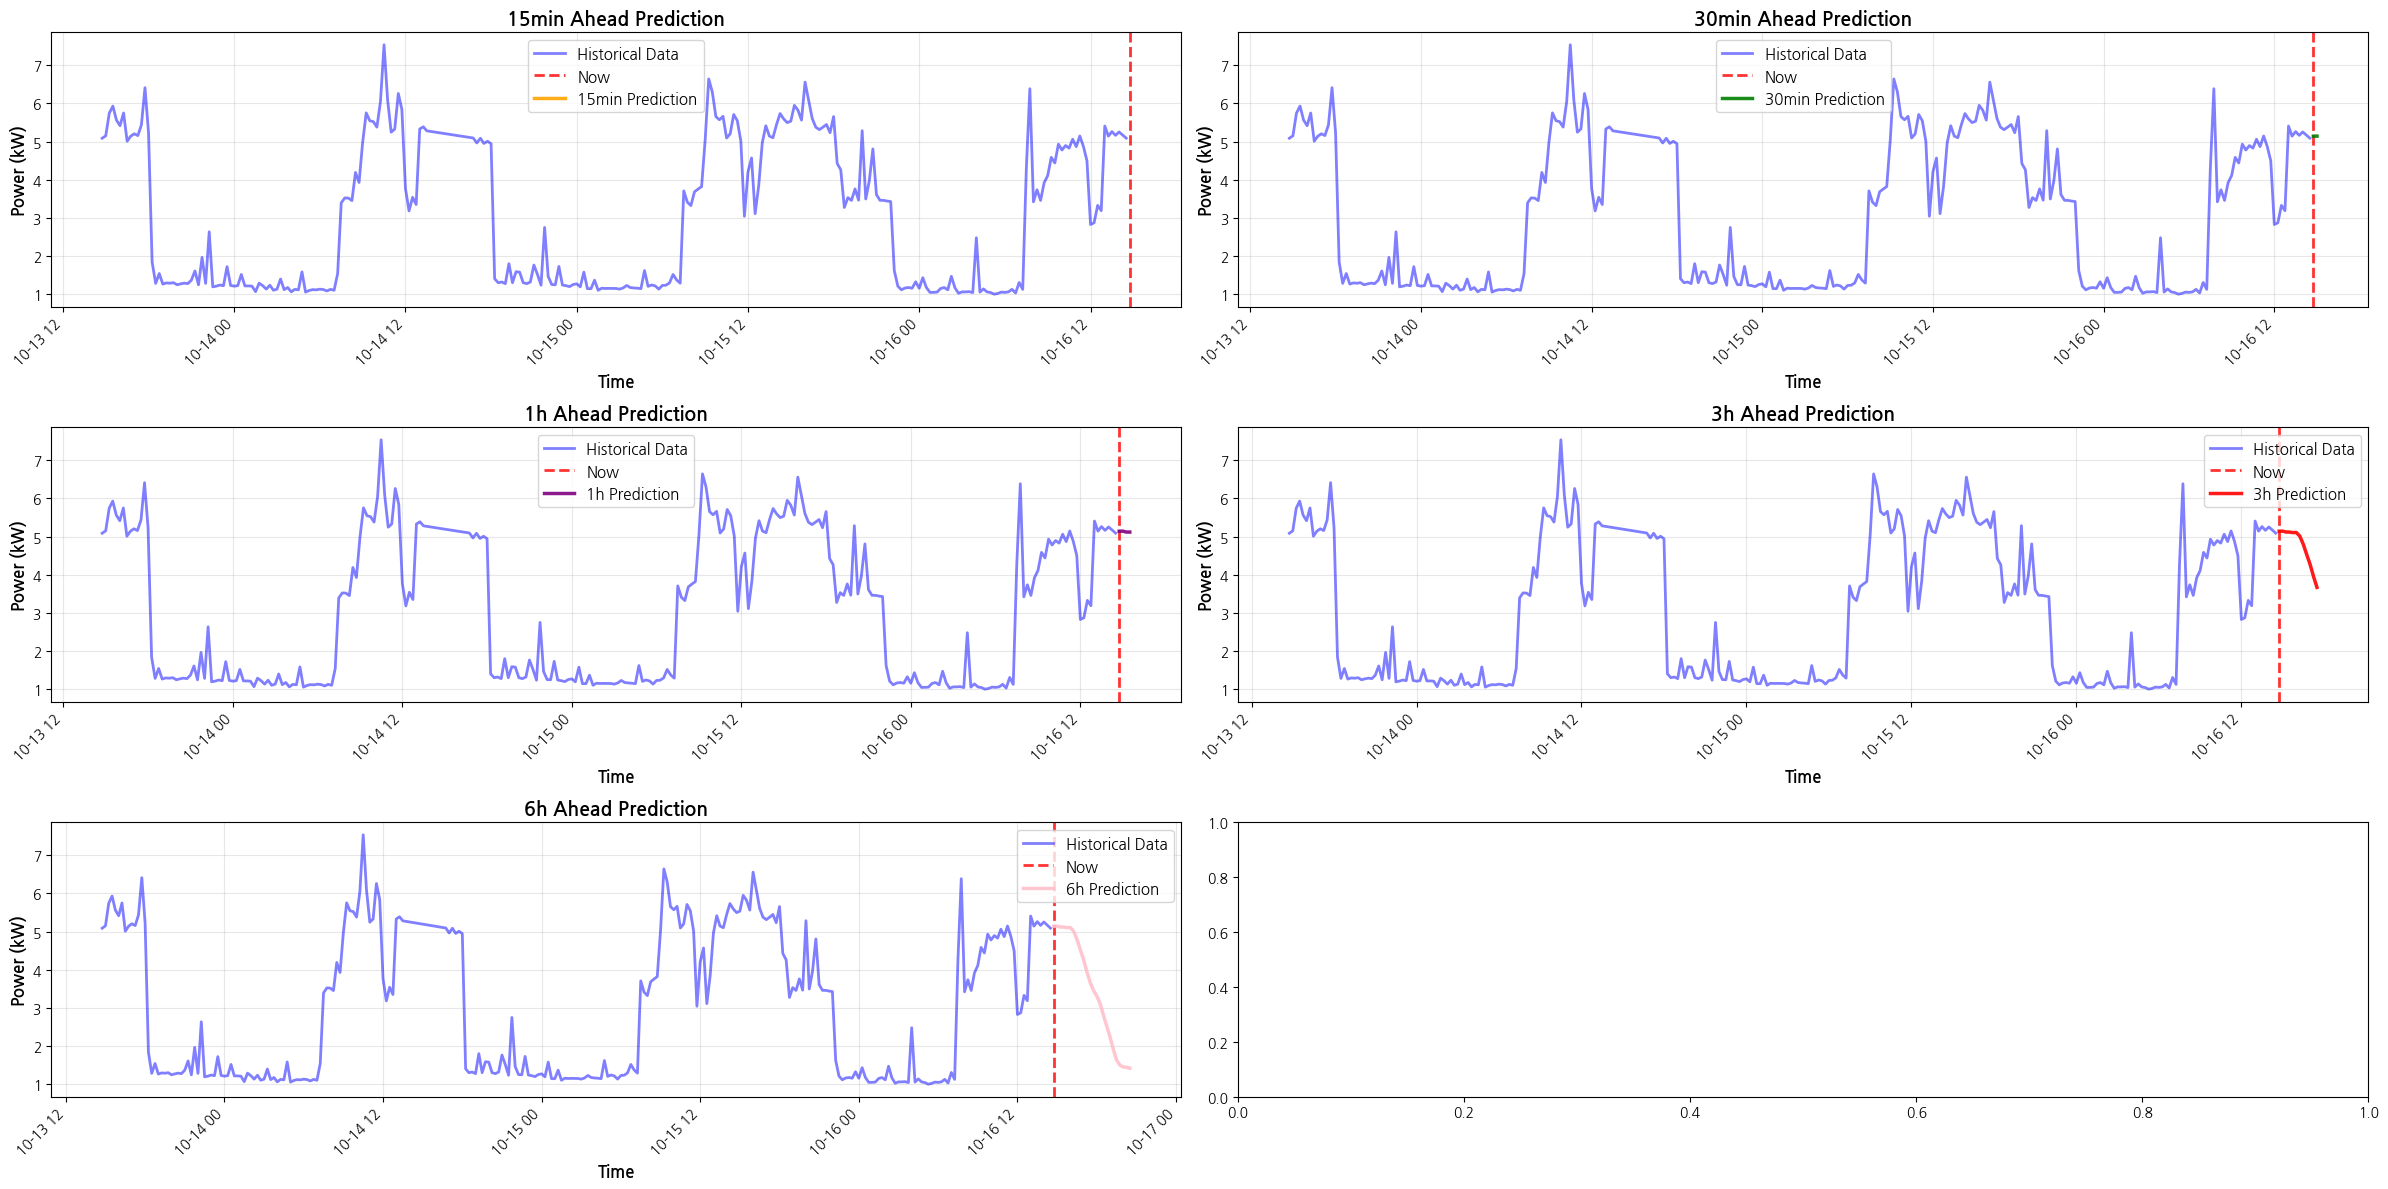

다중 구간 비교 그래프 완료


In [ ]:
print("\n[시각화 2] 다중 구간 비교 그래프 (2×2)")

fig, axes = plt.subplots(3,2, figsize=(24, 12))
axes = axes.flatten()

# 색상 설정
colors = {'15min': 'orange', '30min': 'green', '1h': 'purple', '3h': 'red', '6h' : 'pink'}

# 순서 지정 (딕셔너리 순서 보장)
horizons = ['15min', '30min', '1h', '3h', '6h']

# 반복문으로 그래프 그리기
for idx, horizon in enumerate(horizons):
    ax = axes[idx]
    predictions = predictions_dict[horizon]
    pred_times = pred_times_dict[horizon]
    color = colors[horizon]

    # 과거 데이터
    ax.plot(historical_data['ts'], historical_data['current_power_kw'],
            label='Historical Data', color='blue', linewidth=2, alpha=0.5)

    # 예측 시작점
    ax.axvline(x=prediction_start_time, color='red', linestyle='--',
               linewidth=2, alpha=0.8, label='Now')

    # 예측 데이터
    ax.plot(pred_times, predictions,
            label=f'{horizon} Prediction',
            color=color, linewidth=2.5, alpha=0.9)

    # 그래프 설정
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Power (kW)', fontsize=12, fontweight='bold')
    ax.set_title(f'{horizon} Ahead Prediction', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("다중 구간 비교 그래프 완료")


[시각화 3] 모든 예측 구간 통합 그래프


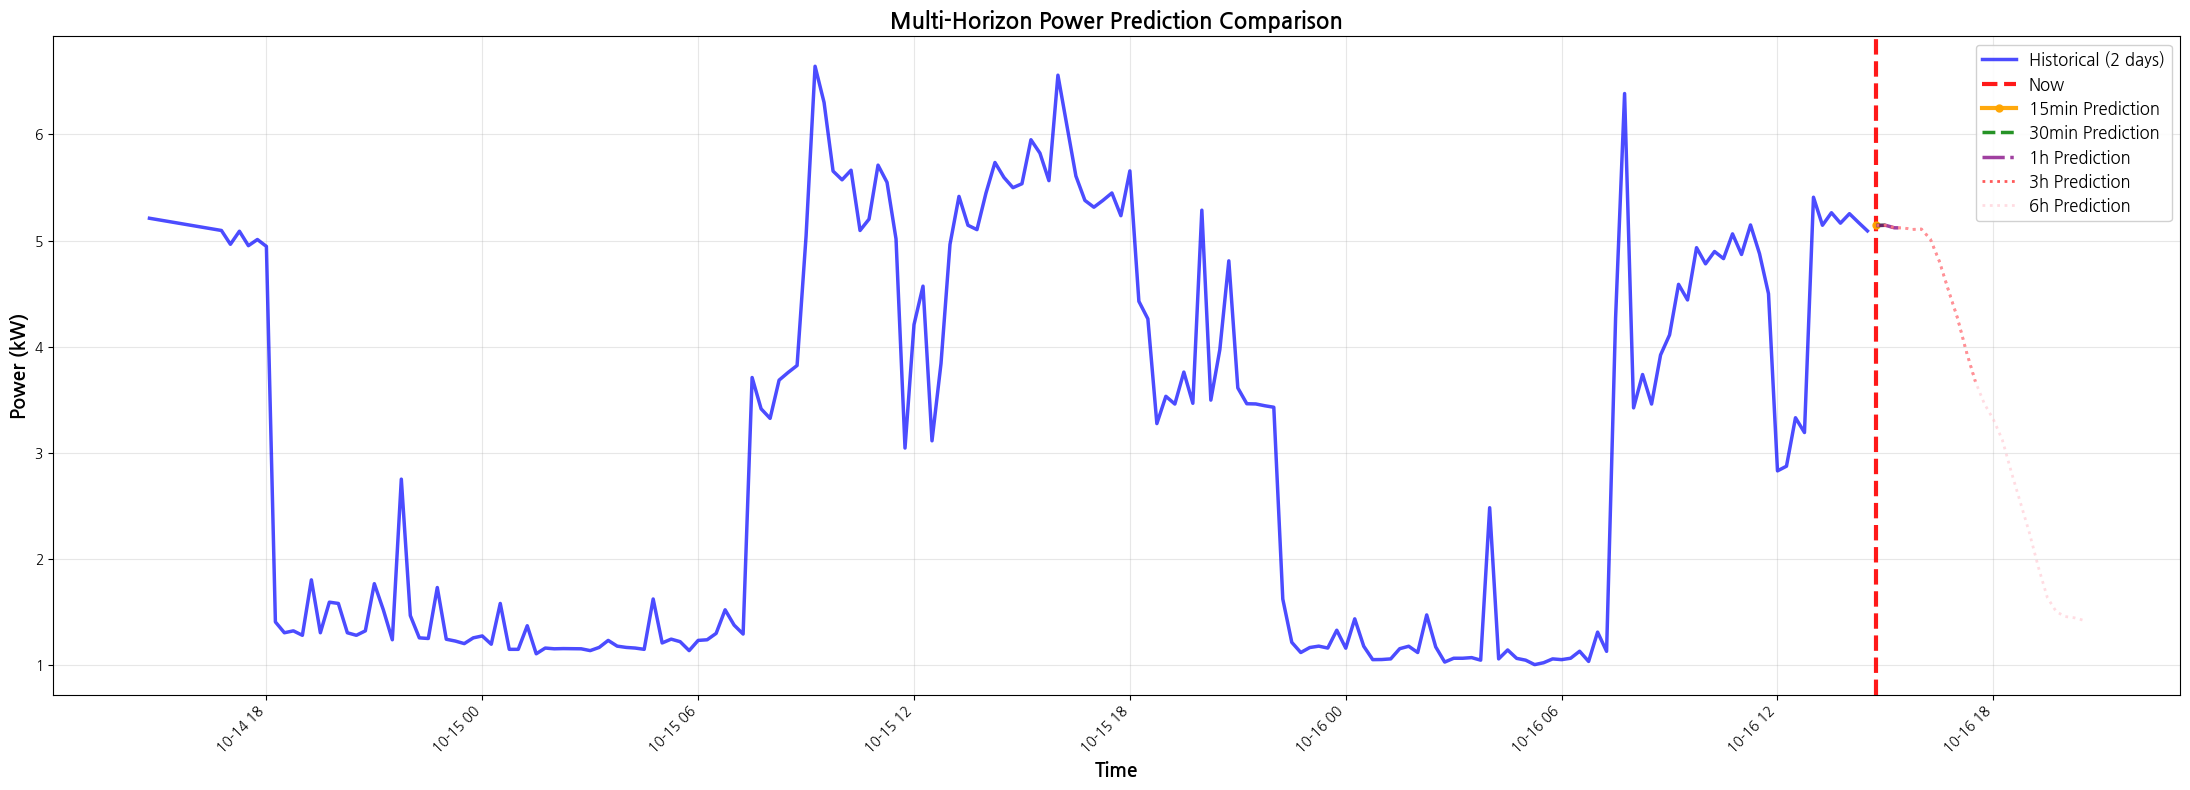

통합 비교 그래프 완료


In [ ]:
print("\n[시각화 3] 모든 예측 구간 통합 그래프")

# 최근 2일 데이터만 표시 (가독성)
recent_data = data.iloc[-192:].copy()  # 192 = 2일

plt.figure(figsize=(22, 8))

# 과거 데이터
plt.plot(recent_data['ts'], recent_data['current_power_kw'],
         label='Historical (2 days)', color='blue', linewidth=2.5, alpha=0.7)

# 예측 시작점
plt.axvline(x=prediction_start_time, color='red', linestyle='--',
            linewidth=3, label='Now', alpha=0.9)

# 선 스타일 설정
line_styles = {
    '15min': {'linestyle': '-', 'linewidth': 3, 'alpha': 0.95, 'marker': 'o', 'markersize': 5},
    '30min': {'linestyle': '--', 'linewidth': 2.5, 'alpha': 0.85},
    '1h': {'linestyle': '-.', 'linewidth': 2.5, 'alpha': 0.75},
    '3h': {'linestyle': ':', 'linewidth': 2, 'alpha': 0.65},
    '6h': {'linestyle': ':', 'linewidth': 2, 'alpha': 0.55},
}

# 모든 예측 구간 그리기
for horizon in horizons:
    predictions = predictions_dict[horizon]
    pred_times = pred_times_dict[horizon]
    color = colors[horizon]
    style = line_styles[horizon]

    plt.plot(pred_times, predictions,
             label=f'{horizon} Prediction',
             color=color,
             **style)

# 그래프 설정
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Power (kW)', fontsize=14, fontweight='bold')
plt.title('Multi-Horizon Power Prediction Comparison', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("통합 비교 그래프 완료")

In [ ]:
# 실제 데이터 불러 오기
# 시각화
future_data = pd.read_csv('./improved_data/filled_data_2_improved.csv')
future_data['ts'] = pd.to_datetime(future_data['ts'])

In [ ]:
future_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6217 entries, 0 to 6216
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ts                6217 non-null   datetime64[ns]
 1   current_power_kw  6217 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 97.3 KB


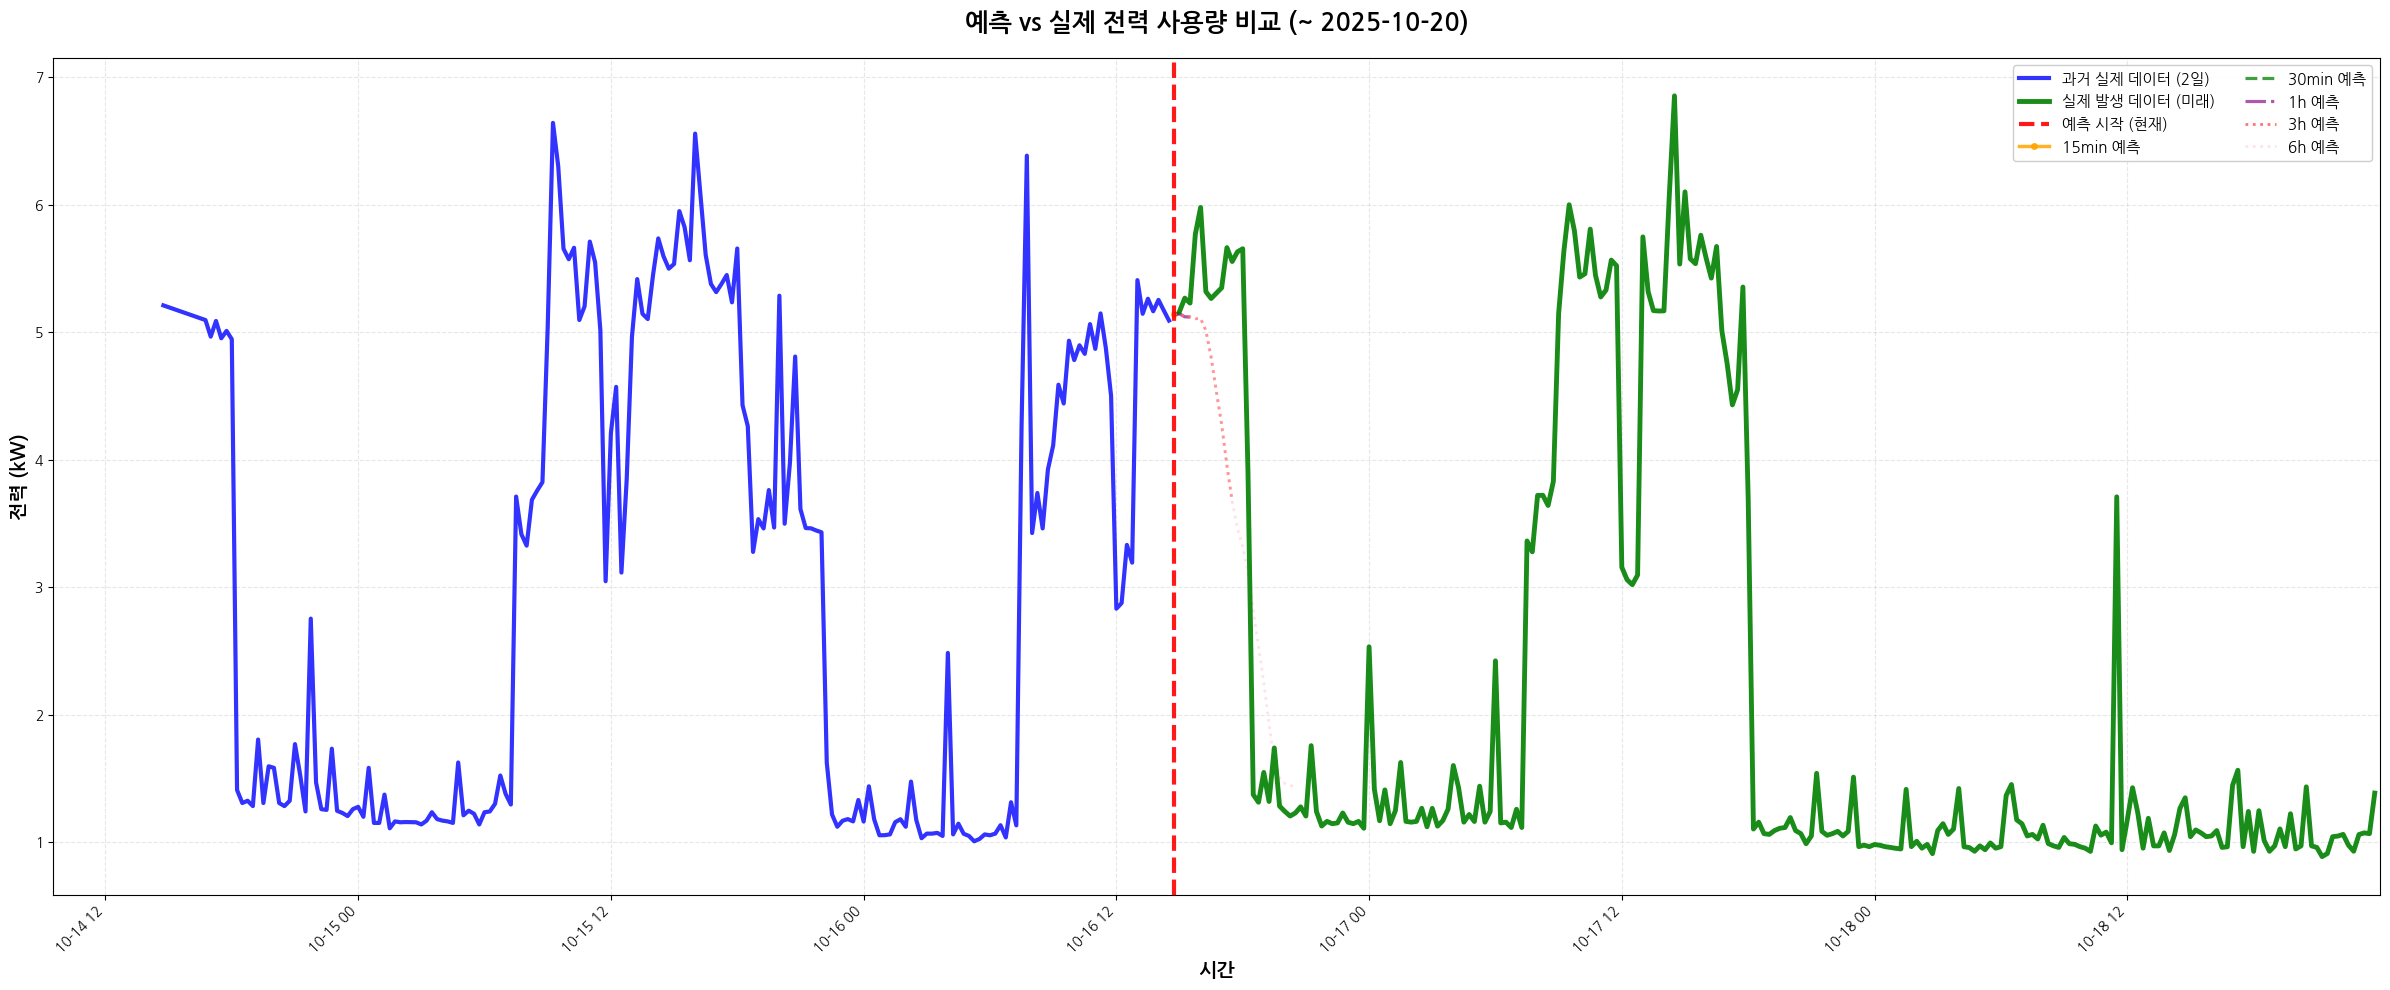

예측 vs 실제 비교 그래프 완료 (2025-10-20까지)


In [ ]:
def plot_prediction_vs_actual(data, future_data, predictions_dict, pred_times_dict,
                               prediction_start_time, horizons, colors):
    """
    예측값과 실제 미래 데이터를 비교하는 시각화 (날짜 범위 제한)
    """
    # 미래 데이터 로드 및 시간 변환
    future_data['ts'] = pd.to_datetime(future_data['ts'])

    # 최근 2일 + 미래 5일 표시
    recent_data = data.iloc[-192:].copy()  # 과거 2일

    # 날짜 범위 설정
    end_date = pd.Timestamp('2025-10-18 23:59:59')

    # 그래프 크기
    plt.figure(figsize=(24, 10))

    # 1. 과거 실제 데이터 (파란색)
    plt.plot(recent_data['ts'], recent_data['current_power_kw'],
             label='과거 실제 데이터 (2일)', color='blue',
             linewidth=3, alpha=0.8, zorder=3)

    # 2. 미래 실제 데이터 (초록색 - 굵게) - 날짜 필터링
    future_mask = (future_data['ts'] > prediction_start_time) & (future_data['ts'] <= end_date)
    future_actual = future_data[future_mask].copy()

    plt.plot(future_actual['ts'], future_actual['current_power_kw'],
             label='실제 발생 데이터 (미래)', color='green',
             linewidth=3.5, alpha=0.9, zorder=4)

    # 3. 예측 시작점
    plt.axvline(x=prediction_start_time, color='red', linestyle='--',
                linewidth=3, label='예측 시작 (현재)', alpha=0.9, zorder=5)

    # 4. 각 예측 구간 그리기 - 날짜 필터링
    line_styles = {
        '15min': {'linestyle': '-', 'linewidth': 2.5, 'alpha': 0.85, 'marker': 'o', 'markersize': 4},
        '30min': {'linestyle': '--', 'linewidth': 2.3, 'alpha': 0.75},
        '1h': {'linestyle': '-.', 'linewidth': 2.3, 'alpha': 0.65},
        '3h': {'linestyle': ':', 'linewidth': 2, 'alpha': 0.55},
        '6h': {'linestyle': ':', 'linewidth': 2, 'alpha': 0.45},
    }

    for horizon in horizons:
        predictions = predictions_dict[horizon]
        pred_times = pred_times_dict[horizon]

        # 날짜 범위 내 예측만 필터링
        mask = [t <= end_date for t in pred_times]
        filtered_times = [t for t, m in zip(pred_times, mask) if m]
        filtered_preds = [p for p, m in zip(predictions, mask) if m]

        if filtered_times:  # 데이터가 있을 때만 그리기
            color = colors[horizon]
            style = line_styles[horizon]

            plt.plot(filtered_times, filtered_preds,
                     label=f'{horizon} 예측',
                     color=color,
                     **style,
                     zorder=2)

    # X축 범위 명시적 설정
    plt.xlim(right=end_date)

    # 그래프 설정
    plt.xlabel('시간', fontsize=14, fontweight='bold')
    plt.ylabel('전력 (kW)', fontsize=14, fontweight='bold')
    plt.title('예측 vs 실제 전력 사용량 비교 (~ 2025-10-20)',
              fontsize=18, fontweight='bold', pad=20)
    plt.legend(fontsize=11, loc='best', framealpha=0.95, ncol=2)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("예측 vs 실제 비교 그래프 완료 (2025-10-20까지)")

# 사용
plot_prediction_vs_actual(data, future_data, predictions_dict, pred_times_dict,
                          prediction_start_time, horizons, colors)

 예측 중...]
15m 완료
 예측 중...]
30m 완료
[1h 예측 중...]
1h 완료
[3h 예측 중...]
3h 완료


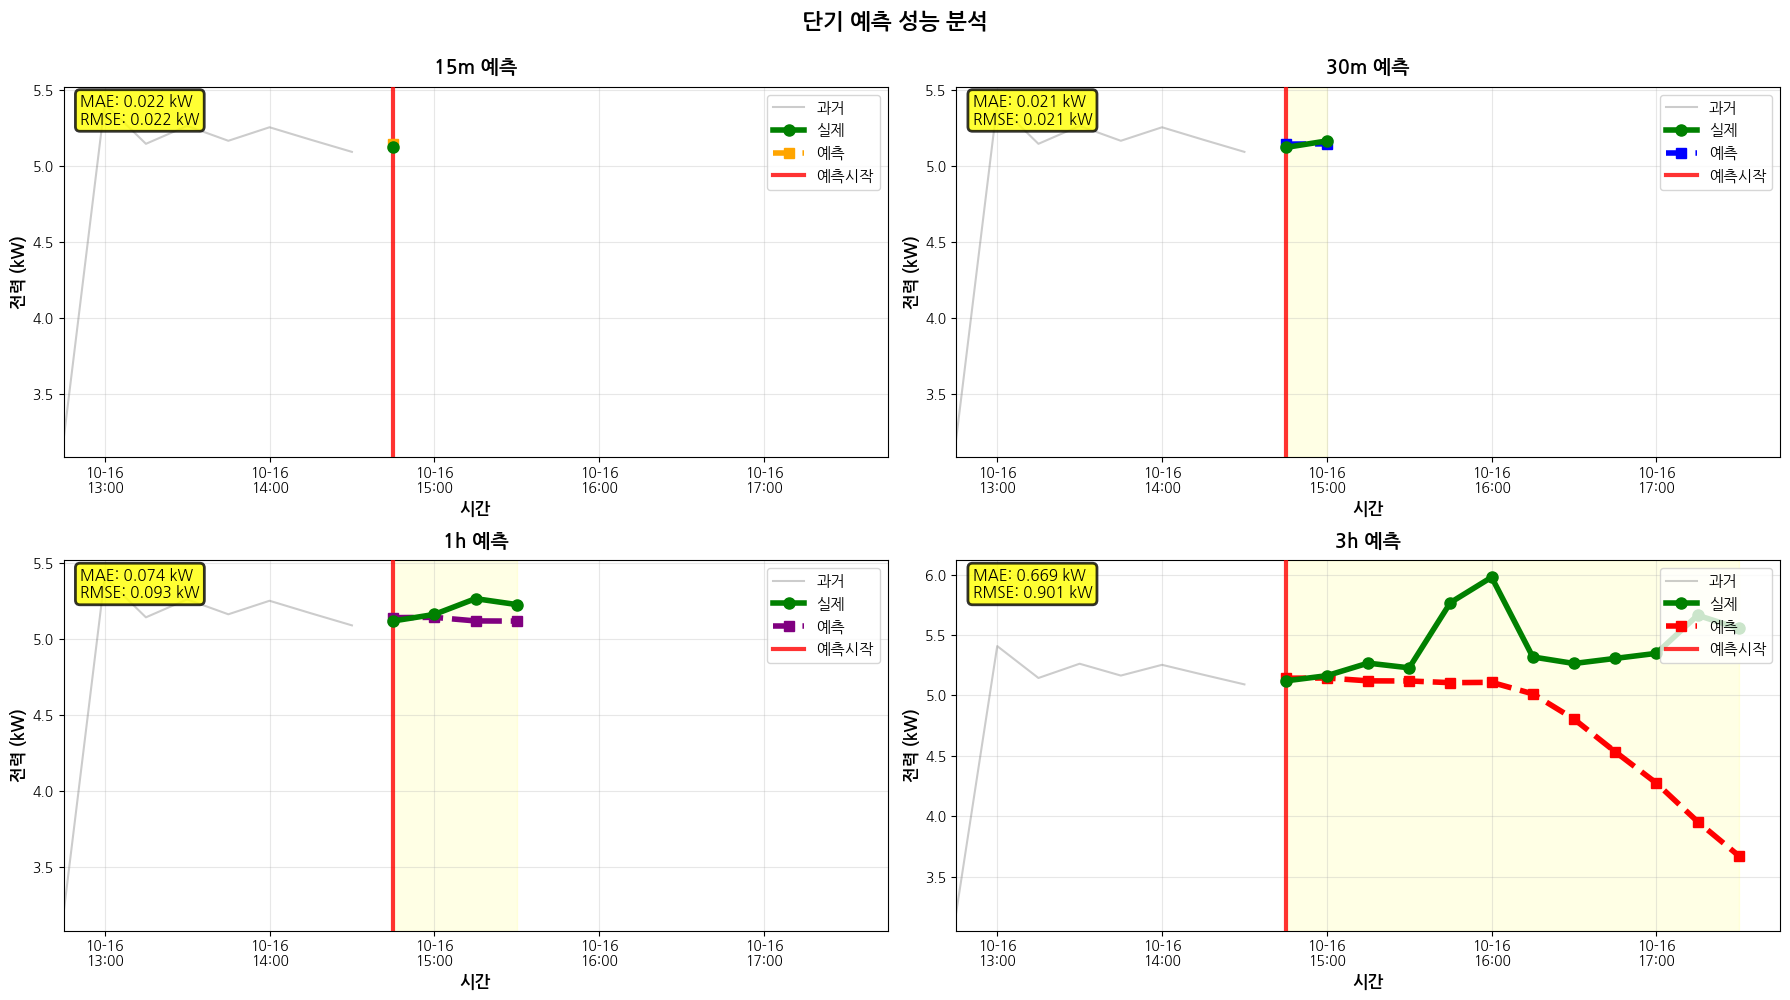

In [ ]:
#예측구간을 좀 더 조밀하게 수정
# 0. color
colors = {'15m': 'orange', '30m': 'blue', '1h': 'purple', '3h': 'red'}
# 1. 예측 설정 수정
predict_config = {
    '15m': 1,      # 15분 = 1 스텝
    '30m': 2,      # 30분 = 2 스텝
    '1h': 4,       # 1시간 = 4 스텝
    '3h': 12,      # 3시간 = 12 스텝
}

# 2. 예측 수행
predictions_dict = {}
pred_times_dict = {}

for horizon, n_steps in predict_config.items():
    print(f"[{horizon} 예측 중...]")

    predictions_dict[horizon] = predict_future_recursive(
        model=model_loaded,
        initial_sequence=initial_sequence,
        scaler_X=scaler_X_loaded,
        scaler_y=scaler_y_loaded,
        n_steps=n_steps,
        feature_cols=feature_columns_loaded,
        seq_len=sequence_length_loaded,
        n_feat=config['n_features'],
        device=device
    )

    pred_times_dict[horizon] = [
        prediction_start_time + pd.Timedelta(minutes=15*i)
        for i in range(n_steps)
    ]

    print(f"{horizon} 완료")

# 3. 시각화
def plot_short_term_predictions_focused(data, future_data, predictions_dict, pred_times_dict,
                                         prediction_start_time, colors):
    future_data['ts'] = pd.to_datetime(future_data['ts'])

    short_horizons = ['15m', '30m', '1h', '3h']

    # 전체 x축 범위 설정 (모든 그래프 동일)
    max_pred_len = max(len(pred_times_dict[h]) for h in short_horizons)
    x_start = prediction_start_time - pd.Timedelta(hours=2)  # 과거 2시간
    x_end = prediction_start_time + pd.Timedelta(minutes=15*max_pred_len)  # 최대 예측 구간

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()

    for idx, horizon in enumerate(short_horizons):
        ax = axes[idx]

        pred_times = pred_times_dict[horizon]
        predictions = predictions_dict[horizon]

        # 과거 데이터 (x축 범위 내)
        past_mask = (data['ts'] >= x_start) & (data['ts'] <= prediction_start_time)
        past_data = data[past_mask].copy()

        # 과거 데이터 그리기
        ax.plot(past_data['ts'], past_data['current_power_kw'],
                label='과거', color='gray', linewidth=1.5, alpha=0.4)

        # 실제 미래
        future_actual_times = []
        future_actual_values = []

        for pred_time in pred_times:
            actual_row = future_data[future_data['ts'] == pred_time]
            if not actual_row.empty:
                future_actual_times.append(pred_time)
                future_actual_values.append(actual_row['current_power_kw'].values[0])

        if future_actual_values:
            ax.plot(future_actual_times, future_actual_values,
                    label='실제', color='green', linewidth=4,
                    marker='o', markersize=8, zorder=5)

            mae = np.mean(np.abs(np.array(predictions[:len(future_actual_values)]) -
                                np.array(future_actual_values)))
            rmse = np.sqrt(np.mean((np.array(predictions[:len(future_actual_values)]) -
                                   np.array(future_actual_values))**2))

            ax.text(0.02, 0.98, f'MAE: {mae:.3f} kW\nRMSE: {rmse:.3f} kW',
                    transform=ax.transAxes, fontsize=11, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='yellow',
                             alpha=0.8, edgecolor='black', linewidth=2))

        # 예측
        ax.plot(pred_times, predictions,
                label='예측', color=colors.get(horizon, 'red'), linewidth=4,
                marker='s', markersize=7, linestyle='--', zorder=4)

        # 예측 시작점
        ax.axvline(x=prediction_start_time, color='red', linestyle='-',
                   linewidth=3, alpha=0.8, label='예측시작', zorder=3)

        # 예측 구간 배경색
        if pred_times:
            ax.axvspan(pred_times[0], pred_times[-1], alpha=0.1, color='yellow')

        # 모든 그래프 x축 범위 동일하게 설정
        ax.set_xlim(x_start, x_end)

        ax.set_xlabel('시간', fontsize=12, fontweight='bold')
        ax.set_ylabel('전력 (kW)', fontsize=12, fontweight='bold')
        ax.set_title(f'{horizon} 예측', fontsize=14, fontweight='bold', pad=10)
        ax.legend(fontsize=11, loc='upper right')
        ax.grid(True, alpha=0.3)

        # x축 포맷 통일
        import matplotlib.dates as mdates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')

    plt.suptitle('단기 예측 성능 분석', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# 실행
plot_short_term_predictions_focused(data, future_data, predictions_dict, pred_times_dict,
                                    prediction_start_time, colors)

# 쓰레기통


In [ ]:
import pandas as pd

# data = data[data['channel_no']==1].sort_values('ts',ascending=True)
# 데이터 전처리가 되어있다고 가정. 실제py파일은 내용을 추가해야함
try:
    df = pd.read_csv('./improved_data/filled_data_improved.csv')
    data = df.copy()

    data['ts'] = pd.to_datetime(data['ts'])

    holidays_list = [

    '2025-01-01','2025-01-27','2025-01-28','2025-01-29','2025-01-30',

    '2025-03-03',

    '2025-05-05','2025-05-06',
    '2025-06-03','2025-06-06',

    '2025-08-15',

    '2025-10-03','2025-10-06','2025-10-07','2025-10-08','2025-10-09',

    '2025-12-25',
    ]
    data['hour']= data['ts'].dt.hour
    data['day_of_week'] = data['ts'].dt.dayofweek
    data['month'] = data['ts'].dt.month

    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)


    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

    data['date_str'] = data['ts'].dt.strftime('%Y-%m-%d')
    data['is_holiday'] = data['date_str'].isin(holidays_list).astype(int)

    data['power_lag_1'] = data['current_power_kw'].shift(1)      # 15분 전
    data['power_lag_4'] = data['current_power_kw'].shift(4)      # 1시간 전
    data['power_lag_12'] = data['current_power_kw'].shift(12)    # 3시간 전
    data['power_lag_96'] = data['current_power_kw'].shift(96)    # 24시간 전

    data['power_diff'] = data['current_power_kw'].diff()        # 15분 변화
    data['power_diff_2'] = data['current_power_kw'].diff(2)     # 30분 변화
    data['power_diff_4'] = data['current_power_kw'].diff(4)     # 1시간 변화

    data['power_accel'] = data['power_diff'].diff()            # 가속도
    data['power_std_12'] = data['current_power_kw'].rolling(12, min_periods=1).std()  # 변동성

    feature_columns = [

    'hour_sin',
    'hour_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'is_weekend',
    'is_holiday',
    'power_lag_1',      # 15분 전
    'power_lag_4',      # 1시간 전
    'power_lag_12',     # 3시간 전
    'power_lag_96',     # 24시간 전 ← 추가
    'power_diff',       # 15분 변화
    'power_diff_2',     # 30분 변화
    'power_diff_4',     # 1시간 변화
    'power_accel',      # 가속도 (diff의 diff즉 급격한 피크를 감지하기 위해서)
    'power_std_12',     # 변동성 (15*12 =180분. 3시간 동안 전력이 얼마나 들쭉날쭉한지를 보기위함)
    ]

    print(" 데이터 로드 성공!")

except FileNotFoundError:
    print(" 파일을 찾을 수 없습니다: filled_data_improved.csv")
    raise


 데이터 로드 성공!


시간을 읽을 수 있는 특성을 추가해 보자
시간, 주말여부, (월. 이건 데이터가 더 많이 모였을 경우 사용하면 좋겠다 ), 휴일 여부

In [ ]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_loss', 'val_loss', 'scaler_X', 'scaler_y', 'feature_columns', 'sequence_length', 'model_config'])

In [ ]:
# 예측 사용자에게 입력을 받는 것을 예시로
#1. 모델 로드
checkpoint = torch.load('gru_model.pth', weights_only = False)

#config = checkpoint['model_config']
#print(f"  - Hidden Size:  {config['hidden_size']}")
#print(f"  - Num Layers:   {config['num_layers']}")
#print(f"  - Dropout:      {config['dropout']}")

In [ ]:
# 모델 학습 시 사용한 설정 불로오기만 사용한다고 했을때 하드 코딩으로 일단 응급처치
n_features = 15
hidden_size = 128
num_layers = 3
dropout = 0.3
batch_size = 64
learning_rate = 0.001

In [ ]:
class SimpleGRU(nn.Module):
    """GRU모델로 다양한 drop out 과 num_layer를 적용 중 hidden_size도 128로 큰 편"""

    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(SimpleGRU, self).__init__()

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,# batch_first 가 False가 기본값인데, True로 해서 배치를 먼저 보게
            dropout=dropout if num_layers > 1 else 0
        )

        # fc1층과 fc2층 즉 2개의 층을 지정.
        # fc는 완전 연결층이라 부른다
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2) # 128, 64
        self.fc2 = nn.Linear(hidden_size // 2, 1)           # 64,   1

        # 활성화 함수로는 ReLU -> 기울기 소실 문제 완화
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.gru(x) # out(64,1)
        out = out[:, -1, :]  # 마지막 타임스텝  (64, 128) ← hidden_size=128

        out = self.fc1(out) # fc1층 (64, 128) → (64, 64)  128 → 64로 압축

        out = self.relu(out) # 음수를 제거 한다. 기울기 소실 문제 해결이 주 목적, 계산이 빠르
        out = self.dropout(out) # 일부를 0으로 dropout

        out = self.fc2(out)  # (64, 64) → (64, 1)로 최종 예측 + (5, 1, 1) → (5,) (마지막 1만 제거)
        return out.squeeze(-1)  #차원 제거 목적 ..마지막 차원이 1이면 제거..
                                # out(64,1)을 1D인 (64,)로 차원을 제거

#모델 설정
#model = SimpleGRU(
#    input_size=n_features,
#    hidden_size=128,
#    num_layers=3,
#    dropout=0.2
#).to(device)

#"학습 가능한 파라미터가 몇 개인가?"
#total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#print(f"모델 파라미터: {total_params:,}개")


In [ ]:
# 새로운 모델 객체 생성 후 가중치 로
model_loaded = SimpleGRU(
    input_size = n_features, # n_features = X.shape[2] # 9
    hidden_size = 128,
    num_layers=3,
    dropout=0.3
).to(device)

model_loaded.load_state_dict(checkpoint['model_state_dict'])
model_loaded.eval() # 평가모드

SimpleGRU(
  (gru): GRU(15, 128, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
# 사용할 스케일러도 불러오기
scaler_X_loaded = checkpoint['scaler_X']
scaler_y_loaded = checkpoint['scaler_y']
feature_columns_loaded = checkpoint['feature_columns']
sequence_length_loaded = checkpoint['sequence_length'] # 96 개의 시퀀스 길이 불러온거

- create_features
- predict_future_recursive

함수 2개 만들기

In [ ]:
import numpy as np
import pandas as pd

# (참고: holidays_list는 이 함수가 호출되는 시점에
#  전역 변수 등으로 미리 정의되어 있어야 합니다.)

def create_features(power_series):
    """
    전력 시계열 *DataFrame*으로부터 특성을 생성하는 함수
    (Sin/Cos 변환 적용)

    Parameters:
    power_series :
    pandas.DataFrame 'ts' 컬럼과 'current_power_kw' 컬럼을 포함하는 DataFrame 시퀀스 (예: 96개 행)

    Returns:
    features : numpy array (15,)
    """

    # 시간 특성 계산

    last_ts = power_series['ts'].iloc[-1]

    # 원본 시간 / 요일 값 계산
    hour = last_ts.hour
    day_of_week = last_ts.dayofweek

    # Sin/Cos 변환 적용
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    day_of_week_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_of_week_cos = np.cos(2 * np.pi * day_of_week / 7)

    # (유지) 휴일/주말 특성
    is_weekend = int(day_of_week in [5, 6])
    date_str = last_ts.strftime('%Y-%m-%d')
    is_holiday = int(date_str in holidays_list)

    if is_holiday == 1:
        is_weekend = 0

    # 2. Lag / Diff 계산 (기존과 동일)

    power_values = power_series['current_power_kw'].values

    power_lag_1 = power_values[-1]
    power_lag_4 = power_values[-4] if len(power_values) >= 4 else power_values[0]
    power_lag_12 = power_values[-12] if len(power_values) >= 12 else power_values[0]
    power_lag_96 = power_values[-96] if len(power_values) >= 96 else power_values[0]

    power_diff = power_values[-1] - power_values[-2] if len(power_values) >= 2 else 0
    power_diff_2 = power_values[-1] - power_values[-3] if len(power_values) >= 3 else 0
    power_diff_4 = power_values[-1] - power_values[-5] if len(power_values) >= 5 else 0

    if len(power_values) >= 3:
        power_accel = power_diff - (power_values[-2] - power_values[-3])
    else:
        power_accel = 0

    power_std_12 = np.std(power_values[-12:]) if len(power_values) >= 12 else 0

    # 반환
    return np.array([
        # 시간/요일 특성 (4개)
        hour_sin,
        hour_cos,
        day_of_week_sin,
        day_of_week_cos,

        # 이벤트 특성 (2개)
        is_weekend,
        is_holiday,

        # Lag/Diff 특성 (8개)
        power_lag_1,
        power_lag_4,
        power_lag_12,
        power_lag_96,
        power_diff,
        power_diff_2,
        power_diff_4,
        power_accel,
        power_std_12
    ])

print("create_features 함수 정의 완료 (Sin/Cos 적용)")

create_features 함수 정의 완료 (Sin/Cos 적용)


In [ ]:
n_features = len(feature_columns)
print(f"새로운 특성 개수: {n_features}") # 15가 나와야 합니다.

새로운 특성 개수: 15


In [ ]:
import torch
# (torch가 이미 import되지 않았다면 추가)

def predict_future_recursive(model, initial_sequence, scaler_X, scaler_y,
                             n_steps, feature_cols, seq_len, n_feat, device):
    """
    재귀적 방식으로 미래 예측 (DataFrame 윈도우 추적 방식)
    예측을 다음 예측의 입력으로 사용하는 Recursive형태
    'create_features'에 DataFrame을 전달하도록 수정됨
    model = 학습된 gru모델
    initial_sequence = 초기 96개 데이터
    scaler_X = X스케일러 (minmaxscaler)
    scaler_y = y스케일러
    n_steps =몇 스텝을 예측할 건지
    feature_cols = 특성 컬럼명 리스트
    seq_len =시퀀스 길이(96)
    n_feat = 특성 개수(ex 15)
    device = (cuda or cpu)
    """
    model.eval() # 평가 모드 돌입
    predictions = [] # 예측 값을 저장할 리스트

    # 1. 'create_features' 함수에 전달할 DataFrame 윈도우
    current_raw_df = initial_sequence[['ts', 'current_power_kw']].copy()

    # 2. 모델 입력을 위한 '특성' NumPy 배열 값들
    current_sequence = initial_sequence[feature_cols].values

    with torch.no_grad(): # gradient 계산 안 함 (예측만 할것)
        for step in range(n_steps): # n_steps 번 반복

            # 3. 스케일링 예시 => (96, 15) → (96*15) → 스케일링 → 다시 (96, 15) → (1, 96, 15)
            seq_scaled = scaler_X.transform(current_sequence.reshape(-1, n_feat)) # transform은 2D형태로 적용가능
            seq_scaled = seq_scaled.reshape(1, seq_len, n_feat) # (1, 96, 15)

            # 4. 모델 예측
            seq_tensor = torch.FloatTensor(seq_scaled).to(device)
            pred_scaled = model(seq_tensor).cpu().numpy() # 출력: 0~1 사이 scaled 값 (1개)

            # 5. 역스케일링
            pred_original = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0] # 마찬가지로 스케일링 3D -> 2D -> 3D
            predictions.append(pred_original) # []에 추가

            # 6. 'DataFrame 윈도우' 업데이트 (핵심!) 15분 추가
            last_ts = current_raw_df['ts'].iloc[-1] # 예: 2025-10-15 12:00
            next_ts = last_ts + pd.Timedelta(minutes=15) # → 2025-10-15 12:15

            new_raw_row = pd.DataFrame({
                'ts': [next_ts], # 15분 추가된 값을
                'current_power_kw': [pred_original] # 예측 하도록 할 것
            })
            # 윈도우 슬라이딩: 맨 앞 1개 제거 + 맨 뒤에 새 행 추가
            current_raw_df = pd.concat( # a에 b를 붙인다
                [current_raw_df.iloc[1:], new_raw_row], #  concat(앞 1개를 제거한 형태, 뒤에 1개 추가) 하여 96개의 행을 유지하도록
                ignore_index=True
            )

            # 7. 'create_features'에 DataFrame 전달 (핵심!)
            # current_raw_df (96행)를 받아서
            # → lag, diff, sin/cos 등 모든 특성 재계산
            # → 마지막 행의 특성값 (1행 × 15개) 반환
            new_features = create_features(current_raw_df)

            # 8. '모델 입력 시퀀스' 업데이트
            current_sequence = np.vstack([current_sequence[1:], new_features]) # 앞 1개 제거 (95개)이후 뒤에 1개 추가하여 업데이트

    return predictions

print("(predict_future_recursive 함수 정의 완료 (DataFrame 전달용)")

(predict_future_recursive 함수 정의 완료 (DataFrame 전달용)


In [ ]:
# 예측 수행
# 초기 시퀀스: 마지막 96개 데이터 사용
initial_sequence = data.iloc[-sequence_length_loaded:].copy()

# 예측 시작 시각 (마지막 데이터 + 15분)
prediction_start_time = initial_sequence['ts'].iloc[-1] + pd.Timedelta(minutes=15)

print(f"\n현재 시각(마지막 데이터가 측정된 시간): {initial_sequence['ts'].iloc[-1]}")
print(f"예측 시작 시각: {prediction_start_time}")
print(f"초기 시퀀스 기간: {initial_sequence['ts'].iloc[0]} ~ {initial_sequence['ts'].iloc[-1]}")
print(f"초기 시퀀스 데이터 개수: {len(initial_sequence)}개")
print(f"현재 전력: {initial_sequence['current_power_kw'].iloc[-1]:.2f} kW")


현재 시각(마지막 데이터가 측정된 시간): 2025-10-16 14:30:00
예측 시작 시각: 2025-10-16 14:45:00
초기 시퀀스 기간: 2025-10-15 14:45:00 ~ 2025-10-16 14:30:00
초기 시퀀스 데이터 개수: 96개
현재 전력: 5.09 kW


In [ ]:
predict_config = {
    '15min': 1,      # 1시간 = 4 스텝
    '30min': 2,     # 3시간 = 12 스텝
    '1h': 4,     # 6시간 = 24 스텝
    '3h': 12,     # 24시간 = 96 스텝
    '6h': 24
}

# 예측 결과를 저장할 딕셔너리
predictions_dict = {}
pred_times_dict = {}

# 반복문으로 예측 + 타임스탬프 생성
for horizon, n_steps in predict_config.items():
    print(f"\n[{horizon} 예측 시작]")

    # 예측 수행
    # 위에서 정의했던 predict_future_recursive를 통해 예측의 prediction 리스트 [] 를 생성하고 그걸 predictions_dict[horizon]에 넣는다.

    predictions_dict[horizon] = predict_future_recursive(
        model=model_loaded,
        initial_sequence=initial_sequence,
        scaler_X=scaler_X_loaded,
        scaler_y=scaler_y_loaded,
        n_steps=n_steps,
        feature_cols=feature_columns_loaded,
        seq_len=sequence_length_loaded,
        n_feat=n_features,
        device=device
    )

    # 타임스탬프 생성
    pred_times_dict[horizon] = [
        prediction_start_time + pd.Timedelta(minutes=15*i)
        for i in range(n_steps)
    ]

    print(f" {horizon} 예측 완료: {len(predictions_dict[horizon])}개 시점")



in 예측 시작]
 15min 예측 완료: 1개 시점

in 예측 시작]
 30min 예측 완료: 2개 시점

[1h 예측 시작]
 1h 예측 완료: 4개 시점

[3h 예측 시작]
 3h 예측 완료: 12개 시점

[6h 예측 시작]
 6h 예측 완료: 24개 시점


In [ ]:
predictions_dict.keys()

dict_keys(['15min', '30min', '1h', '3h', '6h'])

In [ ]:
print("예측 결과 요약")


current_power = initial_sequence['current_power_kw'].iloc[-1]
print(f"\n현재 전력: {current_power:.2f} kW")
print(f"예측 시작: {prediction_start_time}\n")

print(f"{'구간':^10} {'스텝수':^8} {'평균 (kW)':^12}")

for horizon, predictions in predictions_dict.items():
    print(f"{horizon:^10} {len(predictions):^8} "
          f"{np.mean(predictions):^12.2f}")


예측 결과 요약

현재 전력: 5.09 kW
예측 시작: 2025-10-16 14:45:00

    구간       스텝수      평균 (kW)   
  15min       1         5.14    
  30min       2         5.16    
    1h        4         5.16    
    3h        12        4.65    
    6h        24        3.17    


In [ ]:
# 과거 데이터 (최근 3일)
lookback_days = 3
lookback_samples = 96 * lookback_days  # 96 = 하루 15분 간격
historical_data = data.iloc[-lookback_samples:].copy()

print(f"과거 데이터 준비 완료 (최근 {lookback_days}일)")

과거 데이터 준비 완료 (최근 3일)



[시각화 1] 72시간 예측 그래프


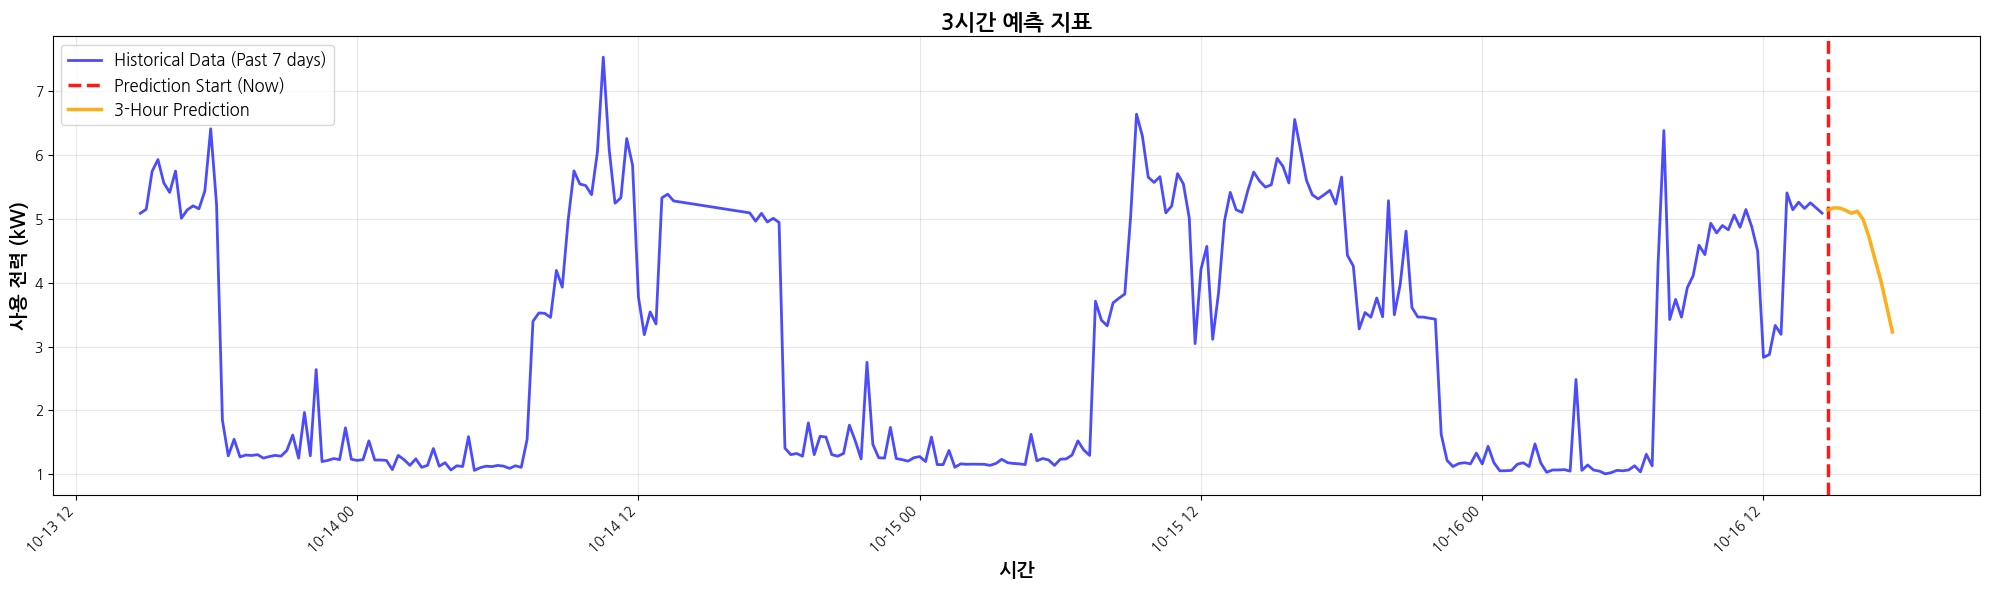

In [ ]:
print("\n[시각화 1] 72시간 예측 그래프")

plt.figure(figsize=(20, 6))

# 과거 데이터 (파란선)
plt.plot(historical_data['ts'], historical_data['current_power_kw'],
         label='Historical Data (Past 7 days)',
         color='blue', linewidth=2, alpha=0.7)

# 예측 시작점 (빨간 점선)
plt.axvline(x=prediction_start_time, color='red', linestyle='--',
            linewidth=2.5, label='Prediction Start (Now)', alpha=0.9)

# 72시간 예측 (주황선)
plt.plot(pred_times_dict['3h'], predictions_dict['3h'],
         label='3-Hour Prediction',
         color='orange', linewidth=2.5, alpha=0.9)

# 그래프 꾸미기
plt.xlabel('시간', fontsize=14, fontweight='bold')
plt.ylabel('사용 전력 (kW)', fontsize=14, fontweight='bold')
plt.title('3시간 예측 지표', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


[시각화 2] 다중 구간 비교 그래프 (2×2)


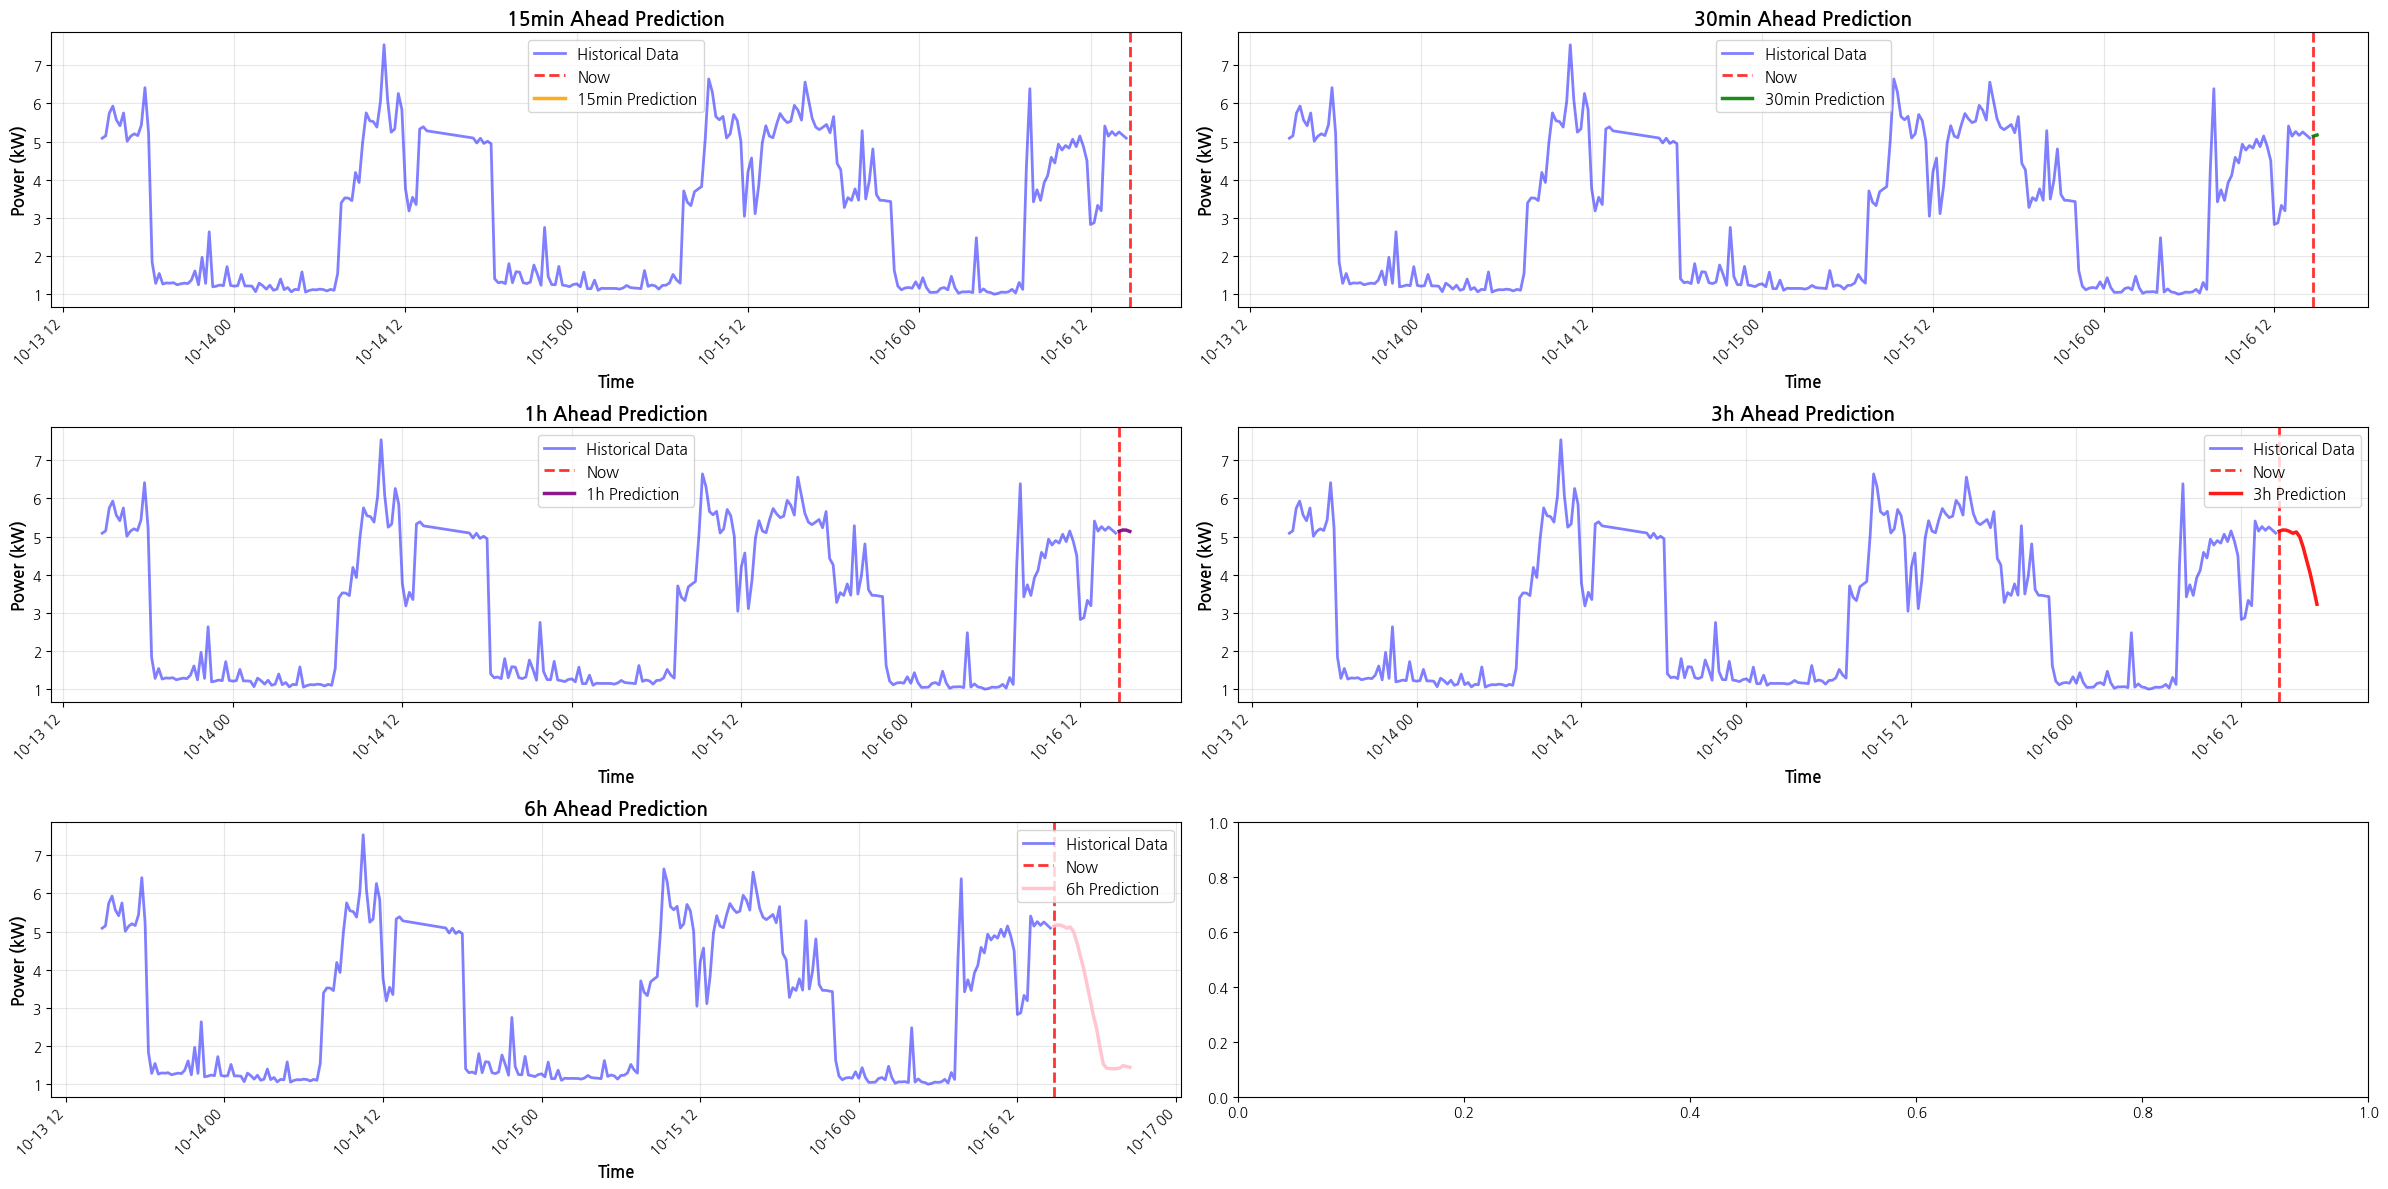

다중 구간 비교 그래프 완료


In [ ]:
print("\n[시각화 2] 다중 구간 비교 그래프 (2×2)")

fig, axes = plt.subplots(3,2, figsize=(24, 12))
axes = axes.flatten()

# 색상 설정
colors = {'15min': 'orange', '30min': 'green', '1h': 'purple', '3h': 'red', '6h' : 'pink'}

# 순서 지정 (딕셔너리 순서 보장)
horizons = ['15min', '30min', '1h', '3h', '6h']

# 반복문으로 그래프 그리기
for idx, horizon in enumerate(horizons):
    ax = axes[idx]
    predictions = predictions_dict[horizon]
    pred_times = pred_times_dict[horizon]
    color = colors[horizon]

    # 과거 데이터
    ax.plot(historical_data['ts'], historical_data['current_power_kw'],
            label='Historical Data', color='blue', linewidth=2, alpha=0.5)

    # 예측 시작점
    ax.axvline(x=prediction_start_time, color='red', linestyle='--',
               linewidth=2, alpha=0.8, label='Now')

    # 예측 데이터
    ax.plot(pred_times, predictions,
            label=f'{horizon} Prediction',
            color=color, linewidth=2.5, alpha=0.9)

    # 그래프 설정
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Power (kW)', fontsize=12, fontweight='bold')
    ax.set_title(f'{horizon} Ahead Prediction', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("다중 구간 비교 그래프 완료")


[시각화 3] 모든 예측 구간 통합 그래프


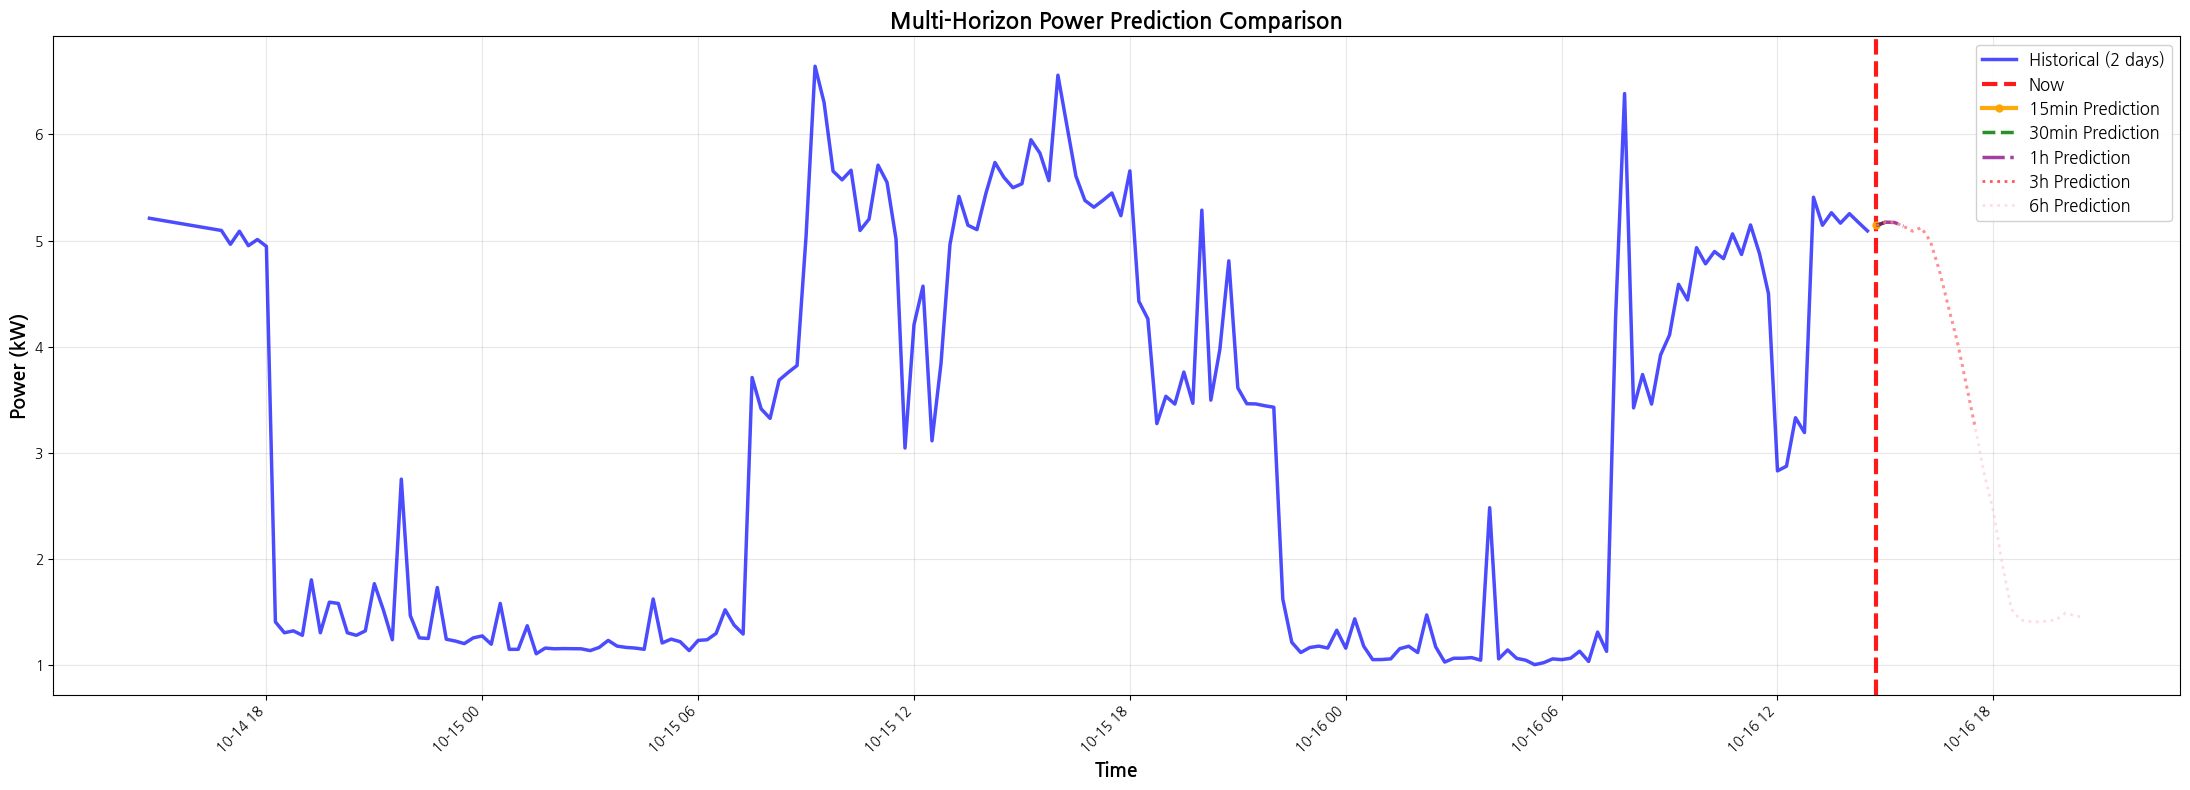

통합 비교 그래프 완료


In [ ]:
print("\n[시각화 3] 모든 예측 구간 통합 그래프")

# 최근 2일 데이터만 표시 (가독성)
recent_data = data.iloc[-192:].copy()  # 192 = 2일

plt.figure(figsize=(22, 8))

# 과거 데이터
plt.plot(recent_data['ts'], recent_data['current_power_kw'],
         label='Historical (2 days)', color='blue', linewidth=2.5, alpha=0.7)

# 예측 시작점
plt.axvline(x=prediction_start_time, color='red', linestyle='--',
            linewidth=3, label='Now', alpha=0.9)

# 선 스타일 설정
line_styles = {
    '15min': {'linestyle': '-', 'linewidth': 3, 'alpha': 0.95, 'marker': 'o', 'markersize': 5},
    '30min': {'linestyle': '--', 'linewidth': 2.5, 'alpha': 0.85},
    '1h': {'linestyle': '-.', 'linewidth': 2.5, 'alpha': 0.75},
    '3h': {'linestyle': ':', 'linewidth': 2, 'alpha': 0.65},
    '6h': {'linestyle': ':', 'linewidth': 2, 'alpha': 0.55},
}

# 모든 예측 구간 그리기
for horizon in horizons:
    predictions = predictions_dict[horizon]
    pred_times = pred_times_dict[horizon]
    color = colors[horizon]
    style = line_styles[horizon]

    plt.plot(pred_times, predictions,
             label=f'{horizon} Prediction',
             color=color,
             **style)

# 그래프 설정
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Power (kW)', fontsize=14, fontweight='bold')
plt.title('Multi-Horizon Power Prediction Comparison', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("통합 비교 그래프 완료")

In [ ]:
# 실제 데이터 불러 오기
# 시각화
future_data = pd.read_csv('./improved_data/filled_data_2_improved.csv')
future_data['ts'] = pd.to_datetime(future_data['ts'])

In [ ]:
future_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6217 entries, 0 to 6216
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ts                6217 non-null   datetime64[ns]
 1   current_power_kw  6217 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 97.3 KB


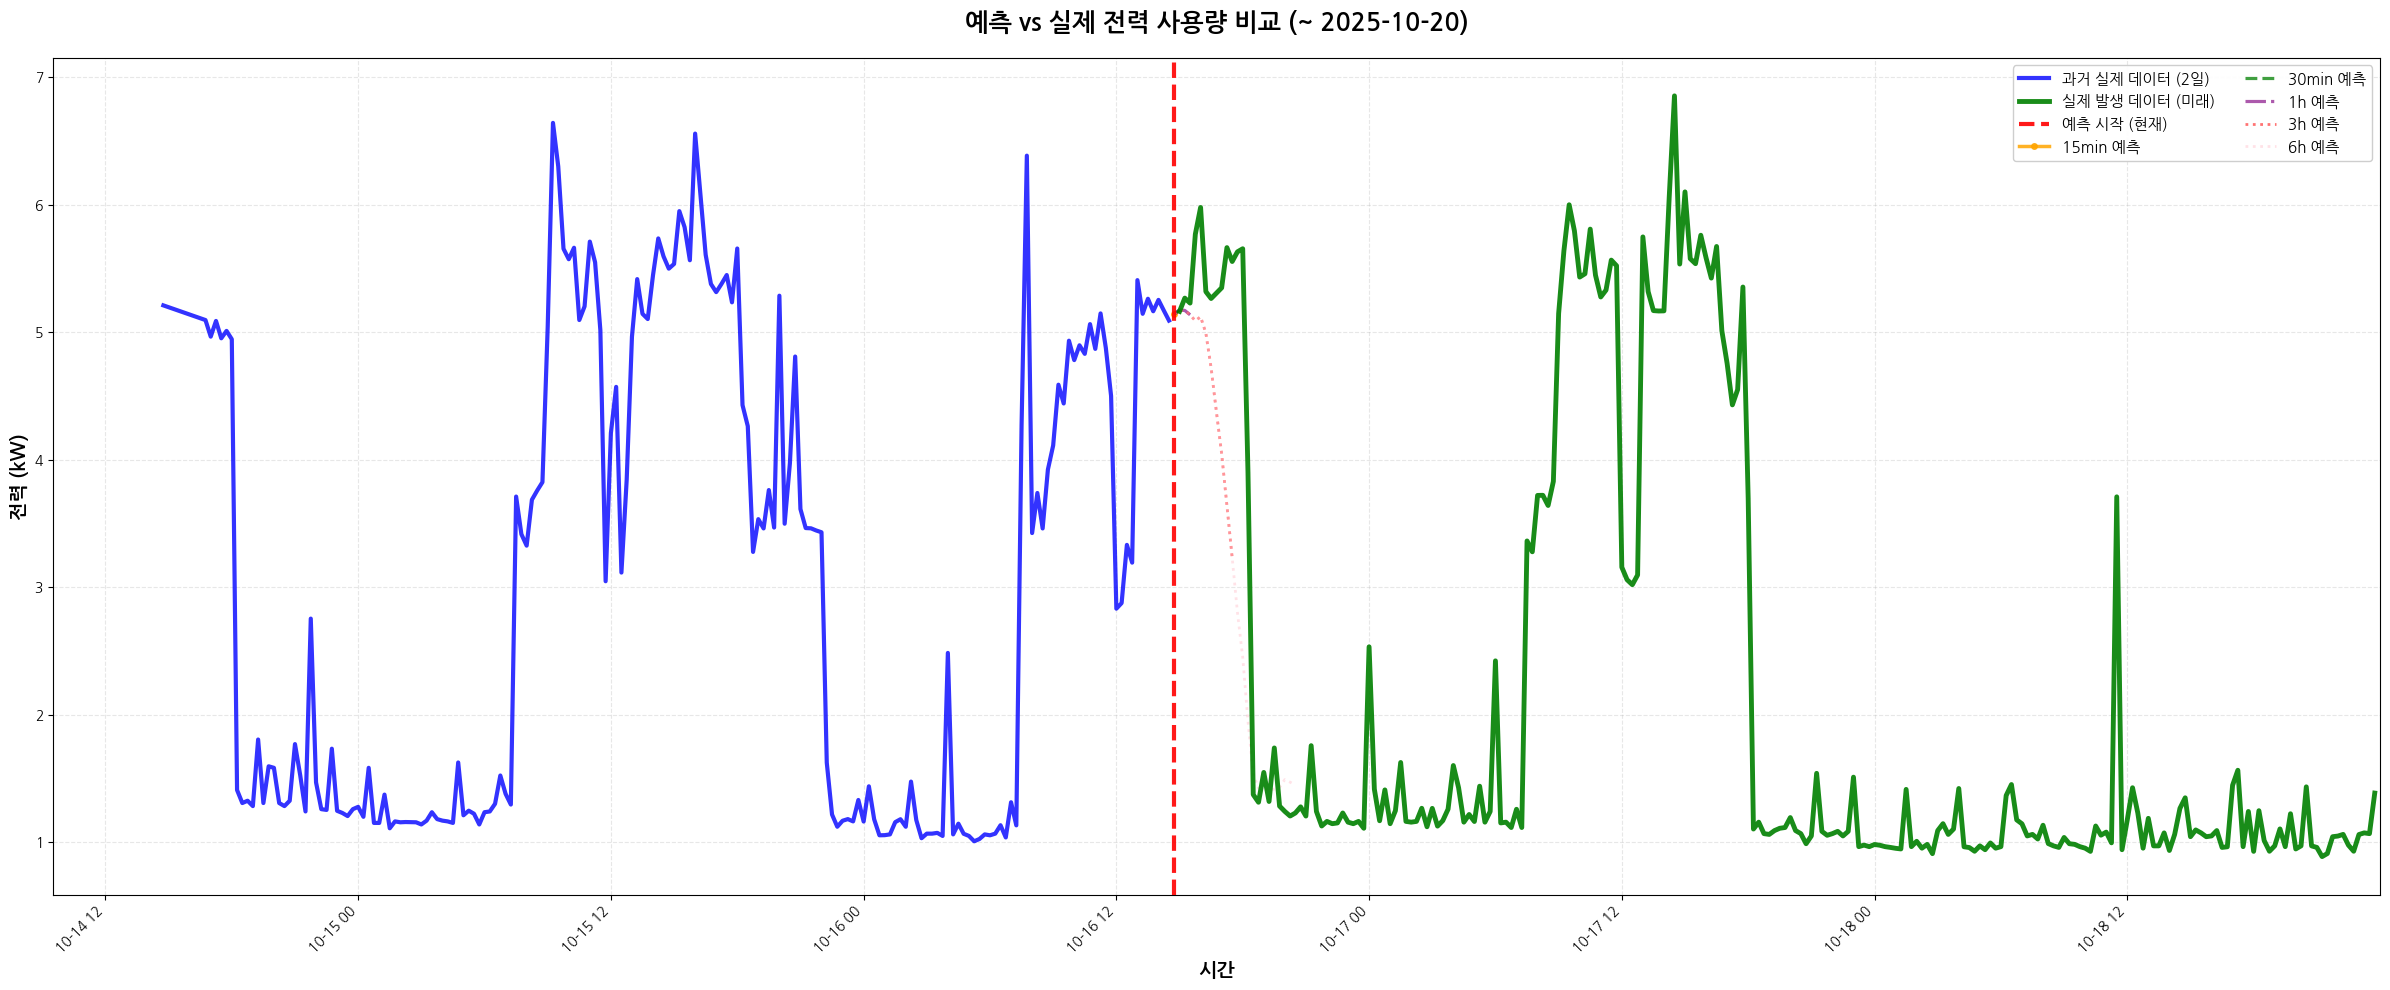

예측 vs 실제 비교 그래프 완료 (2025-10-20까지)


In [ ]:
def plot_prediction_vs_actual(data, future_data, predictions_dict, pred_times_dict,
                               prediction_start_time, horizons, colors):
    """
    예측값과 실제 미래 데이터를 비교하는 시각화 (날짜 범위 제한)
    """
    # 미래 데이터 로드 및 시간 변환
    future_data['ts'] = pd.to_datetime(future_data['ts'])

    # 최근 2일 + 미래 5일 표시
    recent_data = data.iloc[-192:].copy()  # 과거 2일

    # 날짜 범위 설정
    end_date = pd.Timestamp('2025-10-18 23:59:59')

    # 그래프 크기
    plt.figure(figsize=(24, 10))

    # 1. 과거 실제 데이터 (파란색)
    plt.plot(recent_data['ts'], recent_data['current_power_kw'],
             label='과거 실제 데이터 (2일)', color='blue',
             linewidth=3, alpha=0.8, zorder=3)

    # 2. 미래 실제 데이터 (초록색 - 굵게) - 날짜 필터링
    future_mask = (future_data['ts'] > prediction_start_time) & (future_data['ts'] <= end_date)
    future_actual = future_data[future_mask].copy()

    plt.plot(future_actual['ts'], future_actual['current_power_kw'],
             label='실제 발생 데이터 (미래)', color='green',
             linewidth=3.5, alpha=0.9, zorder=4)

    # 3. 예측 시작점
    plt.axvline(x=prediction_start_time, color='red', linestyle='--',
                linewidth=3, label='예측 시작 (현재)', alpha=0.9, zorder=5)

    # 4. 각 예측 구간 그리기 - 날짜 필터링
    line_styles = {
        '15min': {'linestyle': '-', 'linewidth': 2.5, 'alpha': 0.85, 'marker': 'o', 'markersize': 4},
        '30min': {'linestyle': '--', 'linewidth': 2.3, 'alpha': 0.75},
        '1h': {'linestyle': '-.', 'linewidth': 2.3, 'alpha': 0.65},
        '3h': {'linestyle': ':', 'linewidth': 2, 'alpha': 0.55},
        '6h': {'linestyle': ':', 'linewidth': 2, 'alpha': 0.45},
    }

    for horizon in horizons:
        predictions = predictions_dict[horizon]
        pred_times = pred_times_dict[horizon]

        # 날짜 범위 내 예측만 필터링
        mask = [t <= end_date for t in pred_times]
        filtered_times = [t for t, m in zip(pred_times, mask) if m]
        filtered_preds = [p for p, m in zip(predictions, mask) if m]

        if filtered_times:  # 데이터가 있을 때만 그리기
            color = colors[horizon]
            style = line_styles[horizon]

            plt.plot(filtered_times, filtered_preds,
                     label=f'{horizon} 예측',
                     color=color,
                     **style,
                     zorder=2)

    # X축 범위 명시적 설정
    plt.xlim(right=end_date)

    # 그래프 설정
    plt.xlabel('시간', fontsize=14, fontweight='bold')
    plt.ylabel('전력 (kW)', fontsize=14, fontweight='bold')
    plt.title('예측 vs 실제 전력 사용량 비교 (~ 2025-10-20)',
              fontsize=18, fontweight='bold', pad=20)
    plt.legend(fontsize=11, loc='best', framealpha=0.95, ncol=2)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("예측 vs 실제 비교 그래프 완료 (2025-10-20까지)")

# 사용
plot_prediction_vs_actual(data, future_data, predictions_dict, pred_times_dict,
                          prediction_start_time, horizons, colors)

 예측 중...]
15m 완료
 예측 중...]
30m 완료
[1h 예측 중...]
1h 완료
[3h 예측 중...]
3h 완료


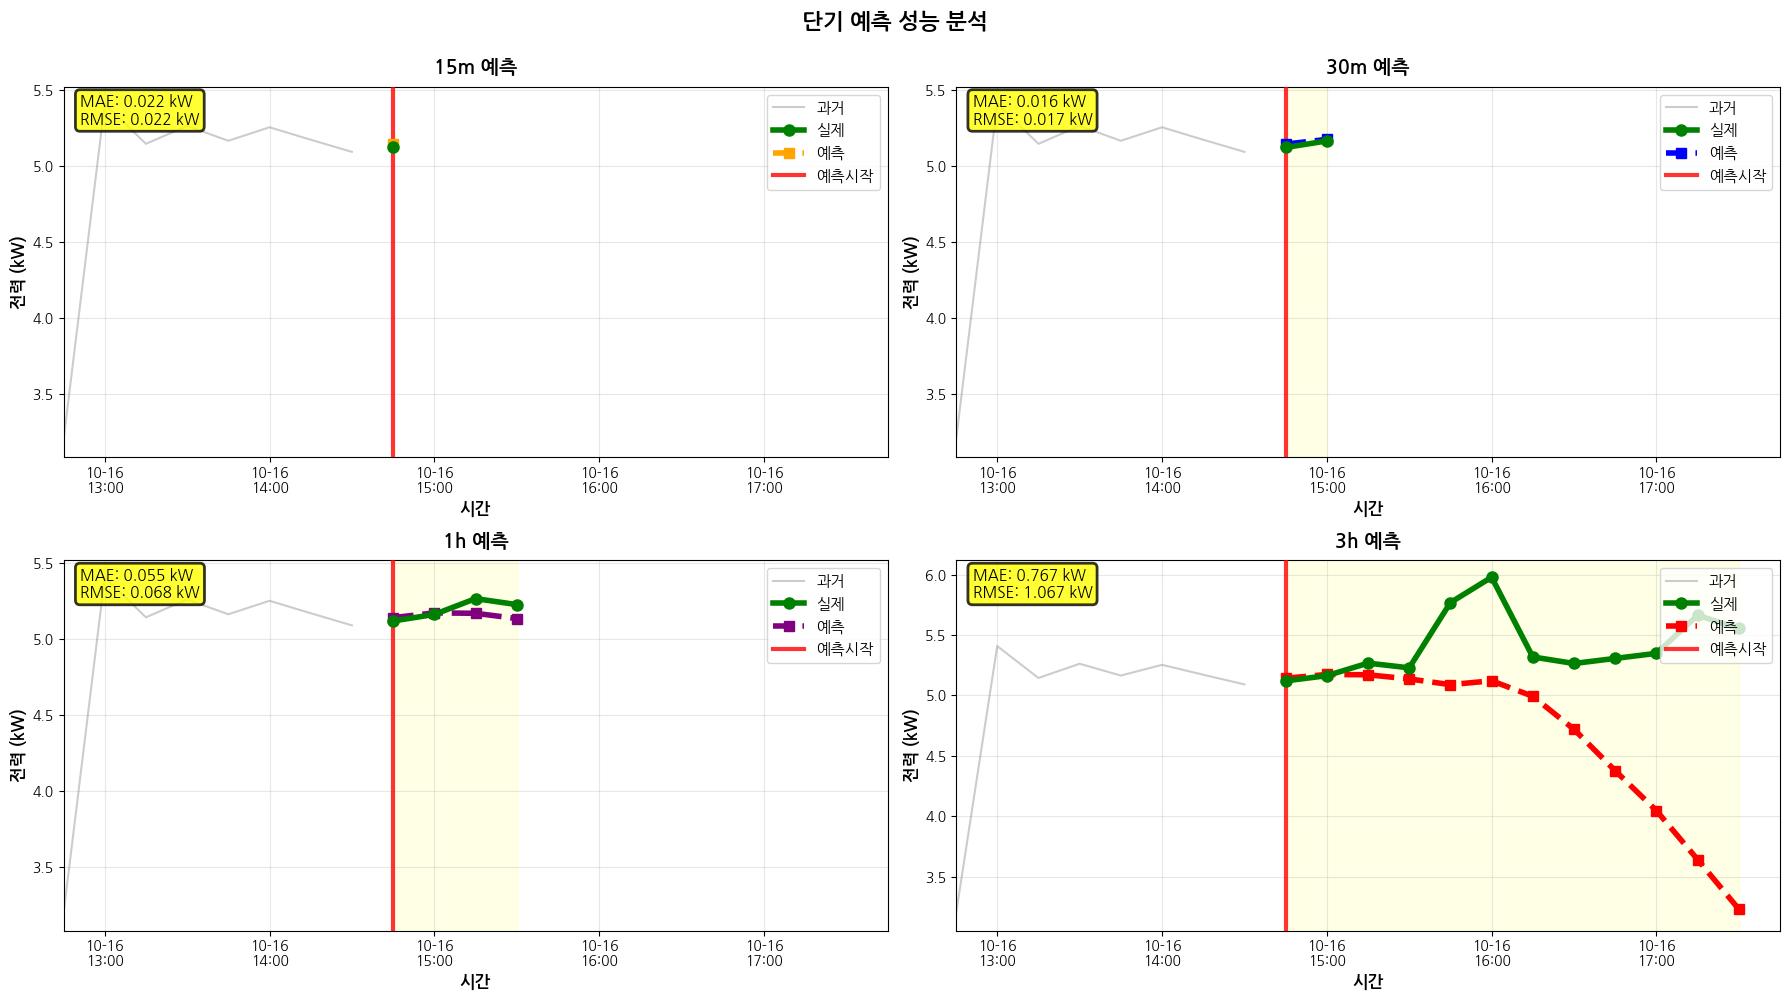

In [ ]:
#예측구간을 좀 더 조밀하게 수정
# 0. color
colors = {'15m': 'orange', '30m': 'blue', '1h': 'purple', '3h': 'red'}
# 1. 예측 설정 수정
predict_config = {
    '15m': 1,      # 15분 = 1 스텝
    '30m': 2,      # 30분 = 2 스텝
    '1h': 4,       # 1시간 = 4 스텝
    '3h': 12,      # 3시간 = 12 스텝
}

# 2. 예측 수행
predictions_dict = {}
pred_times_dict = {}

for horizon, n_steps in predict_config.items():
    print(f"[{horizon} 예측 중...]")

    predictions_dict[horizon] = predict_future_recursive(
        model=model_loaded,
        initial_sequence=initial_sequence,
        scaler_X=scaler_X_loaded,
        scaler_y=scaler_y_loaded,
        n_steps=n_steps,
        feature_cols=feature_columns_loaded,
        seq_len=sequence_length_loaded,
        n_feat=n_features,
        device=device
    )

    pred_times_dict[horizon] = [
        prediction_start_time + pd.Timedelta(minutes=15*i)
        for i in range(n_steps)
    ]

    print(f"{horizon} 완료")

# 3. 시각화
def plot_short_term_predictions_focused(data, future_data, predictions_dict, pred_times_dict,
                                         prediction_start_time, colors):
    future_data['ts'] = pd.to_datetime(future_data['ts'])

    short_horizons = ['15m', '30m', '1h', '3h']

    # 전체 x축 범위 설정 (모든 그래프 동일)
    max_pred_len = max(len(pred_times_dict[h]) for h in short_horizons)
    x_start = prediction_start_time - pd.Timedelta(hours=2)  # 과거 2시간
    x_end = prediction_start_time + pd.Timedelta(minutes=15*max_pred_len)  # 최대 예측 구간

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()

    for idx, horizon in enumerate(short_horizons):
        ax = axes[idx]

        pred_times = pred_times_dict[horizon]
        predictions = predictions_dict[horizon]

        # 과거 데이터 (x축 범위 내)
        past_mask = (data['ts'] >= x_start) & (data['ts'] <= prediction_start_time)
        past_data = data[past_mask].copy()

        # 과거 데이터 그리기
        ax.plot(past_data['ts'], past_data['current_power_kw'],
                label='과거', color='gray', linewidth=1.5, alpha=0.4)

        # 실제 미래
        future_actual_times = []
        future_actual_values = []

        for pred_time in pred_times:
            actual_row = future_data[future_data['ts'] == pred_time]
            if not actual_row.empty:
                future_actual_times.append(pred_time)
                future_actual_values.append(actual_row['current_power_kw'].values[0])

        if future_actual_values:
            ax.plot(future_actual_times, future_actual_values,
                    label='실제', color='green', linewidth=4,
                    marker='o', markersize=8, zorder=5)

            mae = np.mean(np.abs(np.array(predictions[:len(future_actual_values)]) -
                                np.array(future_actual_values)))
            rmse = np.sqrt(np.mean((np.array(predictions[:len(future_actual_values)]) -
                                   np.array(future_actual_values))**2))

            ax.text(0.02, 0.98, f'MAE: {mae:.3f} kW\nRMSE: {rmse:.3f} kW',
                    transform=ax.transAxes, fontsize=11, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='yellow',
                             alpha=0.8, edgecolor='black', linewidth=2))

        # 예측
        ax.plot(pred_times, predictions,
                label='예측', color=colors.get(horizon, 'red'), linewidth=4,
                marker='s', markersize=7, linestyle='--', zorder=4)

        # 예측 시작점
        ax.axvline(x=prediction_start_time, color='red', linestyle='-',
                   linewidth=3, alpha=0.8, label='예측시작', zorder=3)

        # 예측 구간 배경색
        if pred_times:
            ax.axvspan(pred_times[0], pred_times[-1], alpha=0.1, color='yellow')

        # 모든 그래프 x축 범위 동일하게 설정
        ax.set_xlim(x_start, x_end)

        ax.set_xlabel('시간', fontsize=12, fontweight='bold')
        ax.set_ylabel('전력 (kW)', fontsize=12, fontweight='bold')
        ax.set_title(f'{horizon} 예측', fontsize=14, fontweight='bold', pad=10)
        ax.legend(fontsize=11, loc='upper right')
        ax.grid(True, alpha=0.3)

        # x축 포맷 통일
        import matplotlib.dates as mdates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')

    plt.suptitle('단기 예측 성능 분석', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# 실행
plot_short_term_predictions_focused(data, future_data, predictions_dict, pred_times_dict,
                                    prediction_start_time, colors)